In [1]:
# Подключение необходимых библиотек
import random
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.integrate import quad
from numpy import inf, exp
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from scipy.interpolate import make_interp_spline 
from numpy.polynomial import Polynomial

In [2]:
# Параметры образца 

# Материал Ge
Tpr = 77                                # К  - Температура фоторезистора
d = 300e-4                              # см - Толщина фоторезистора 
t = 1e-5                                # сек - время жизни носителей заряда 
A = 1                                   # см^2 - Эффективная площадь
Su = 1e5                                # см/с - Скорость поверхностной рекомбинации на освещаемой поверхности
Sd = 1e10                               # см/с - Скорость поверхностной рекомбинации на тыльной стороне поверхности
Tbb = 2000                              # К - Температура абсолютно черного тела
q = 1.6e-19                             # Кл - Элементарный заряд 
V0 = np.arange(-10, 10, 0.1)            # В - Подаваемое напряжение
c = 3e8                                 # м/с - Скорость света
h = 6.6e-34                             # Дж*с - Постоянная Планка
lambd = np.arange(1e-7, 5e-6, 1e-8)     # массив длин волн
k = 1.3e-23                             # Дж/К - Постоянная Больцмана
Nc = 1.04e19                            # см^-3 - Плотность состояний в зоне проводимости
Nv = 6e19                               # см^-3 - Плотность состояний в валентной зоне
Eg = 0.71                               # эВ - Ширина запрещенной зоны при 77К
exp = 2.72                              # экспонента
n = 4                                   # Коэффициент преломления германия
mn = 0.55*9e-31                         # эффективная масса электрона
mp = 0.37*9e-31                         # эффективная масса дырки
ep = 8.8e-12                            # электрическая постоянная 

 1.1 Выбрать и обосновать свой выбор толщины ФР и время жизни основных носителей;
Исходя из справочных материалов толщина фоторезистора составит 200 мкм а время жизни 1e-5 сек.

In [21]:
ni = np.sqrt(Nc*Nv*(Tpr/300)**3)*exp**(-Eg/(2*8.625e-5*Tpr)) # Расчет собственной концентрации при 77 К
un = 4.9e7*Tpr**(-1.66)                                      # Расчет подвижности электронов при 77 К
up = 1.05e9*Tpr**(-2.33)                                     # Расчет подвижности дырок при 77 К
print(ni)
print(un)
print(up)

1.9155365395476556e-05
36192.74110689889
42234.35921692607


Так как фоторезистор работает при температуре 77 К, то необходимо пересчитать его концентрацию собственных носителей заряда и подвижности.
Собственная концентрация составила 2e-5 см^-3, подвижность электронов 36000 см^2/В*с и подвижность дырок 42000 см^2/В*с.

1.2 Рассчитать темновое сопротивление ФР, построить ВАХ в диапазоне напряжений от −10В до + 10В; 

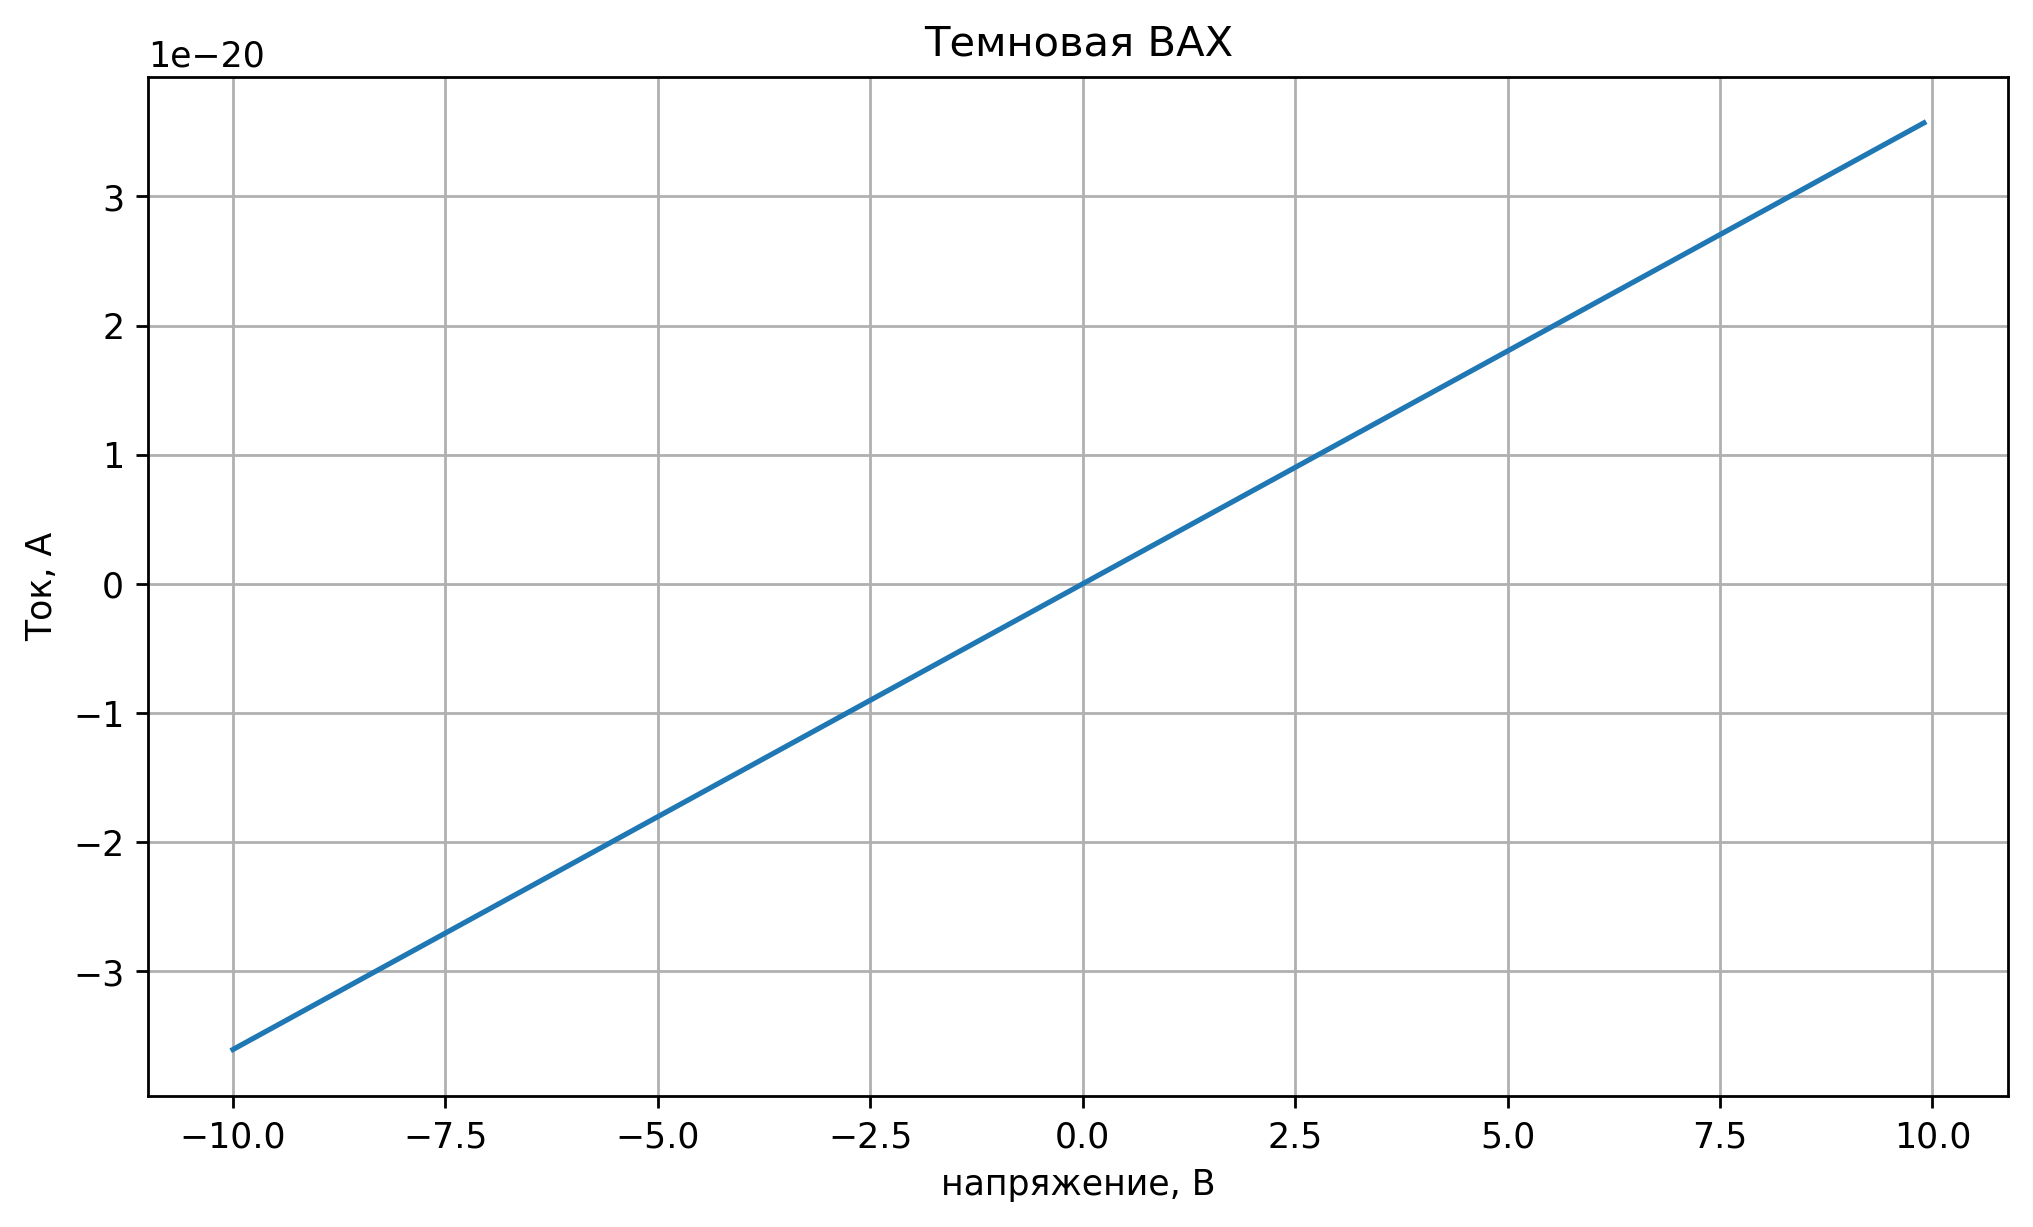

In [22]:

Rt=(1/(q*ni*(un+up)))*(1/d)

Ipht = np.zeros(200)
for i in range(0, 200):
    Ipht[i] = V0[i]/(2*Rt);
 
fig, ax = plt.subplots()        
plt.rcParams['figure.dpi'] = 250 
plt.rcParams["figure.figsize"] = (9.6,5.4)
plt.rcParams["axes.grid"] = True
ax.set_xlabel("напряжение, В") 
ax.set_ylabel("Ток, А") 
ax.set_title('Темновая ВАХ')
ax.plot(V0, Ipht,);



Темновое сопротивление составило 2е20 Ом

1.3 Построить распределение потока энергии и потока фотонов АЧТ при заданной температуре; 

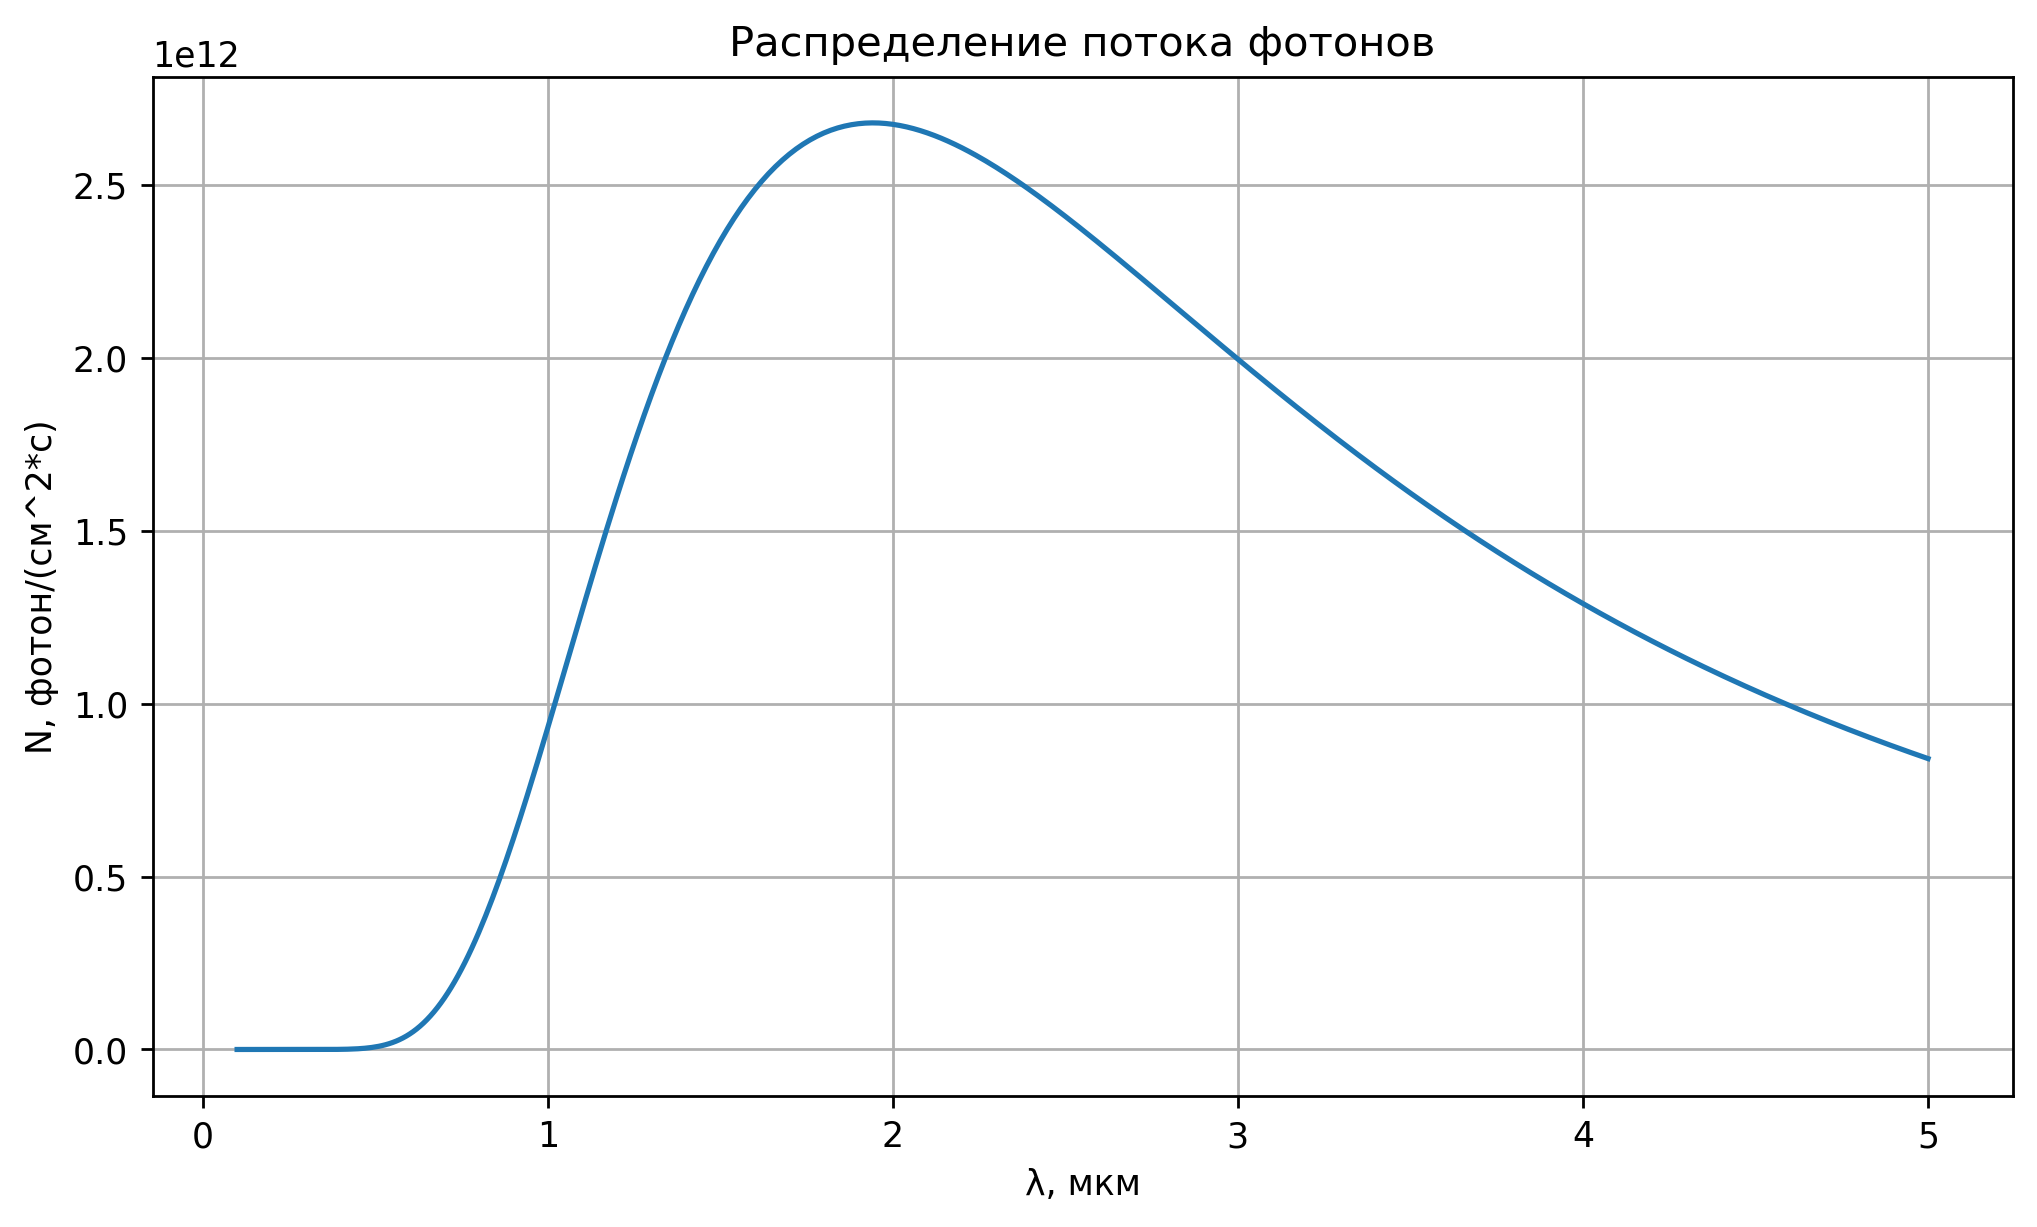

In [5]:
def N(lambd):
    N = np.zeros(len(lambd))
    for i in range(0, len(lambd)):
        N[i] =(2*np.pi*c/(1e18*lambd[i]**4))*(1/(np.exp((h*c)/(lambd[i]*Tbb*k))-1));
    return N

Npht=N(lambd);
fig, ax = plt.subplots()        
plt.rcParams['figure.dpi'] = 250 
plt.rcParams["figure.figsize"] = (9.6,5.4)
plt.rcParams["axes.grid"] = True
ax.set_xlabel("λ, мкм") 
ax.set_ylabel("N, фотон/(см^2*с)") 
ax.set_title('Распределение потока фотонов')
ax.plot(lambd*1e6, Npht,);

(1.3443711555675524e-10, 2.651954279721716e-10)


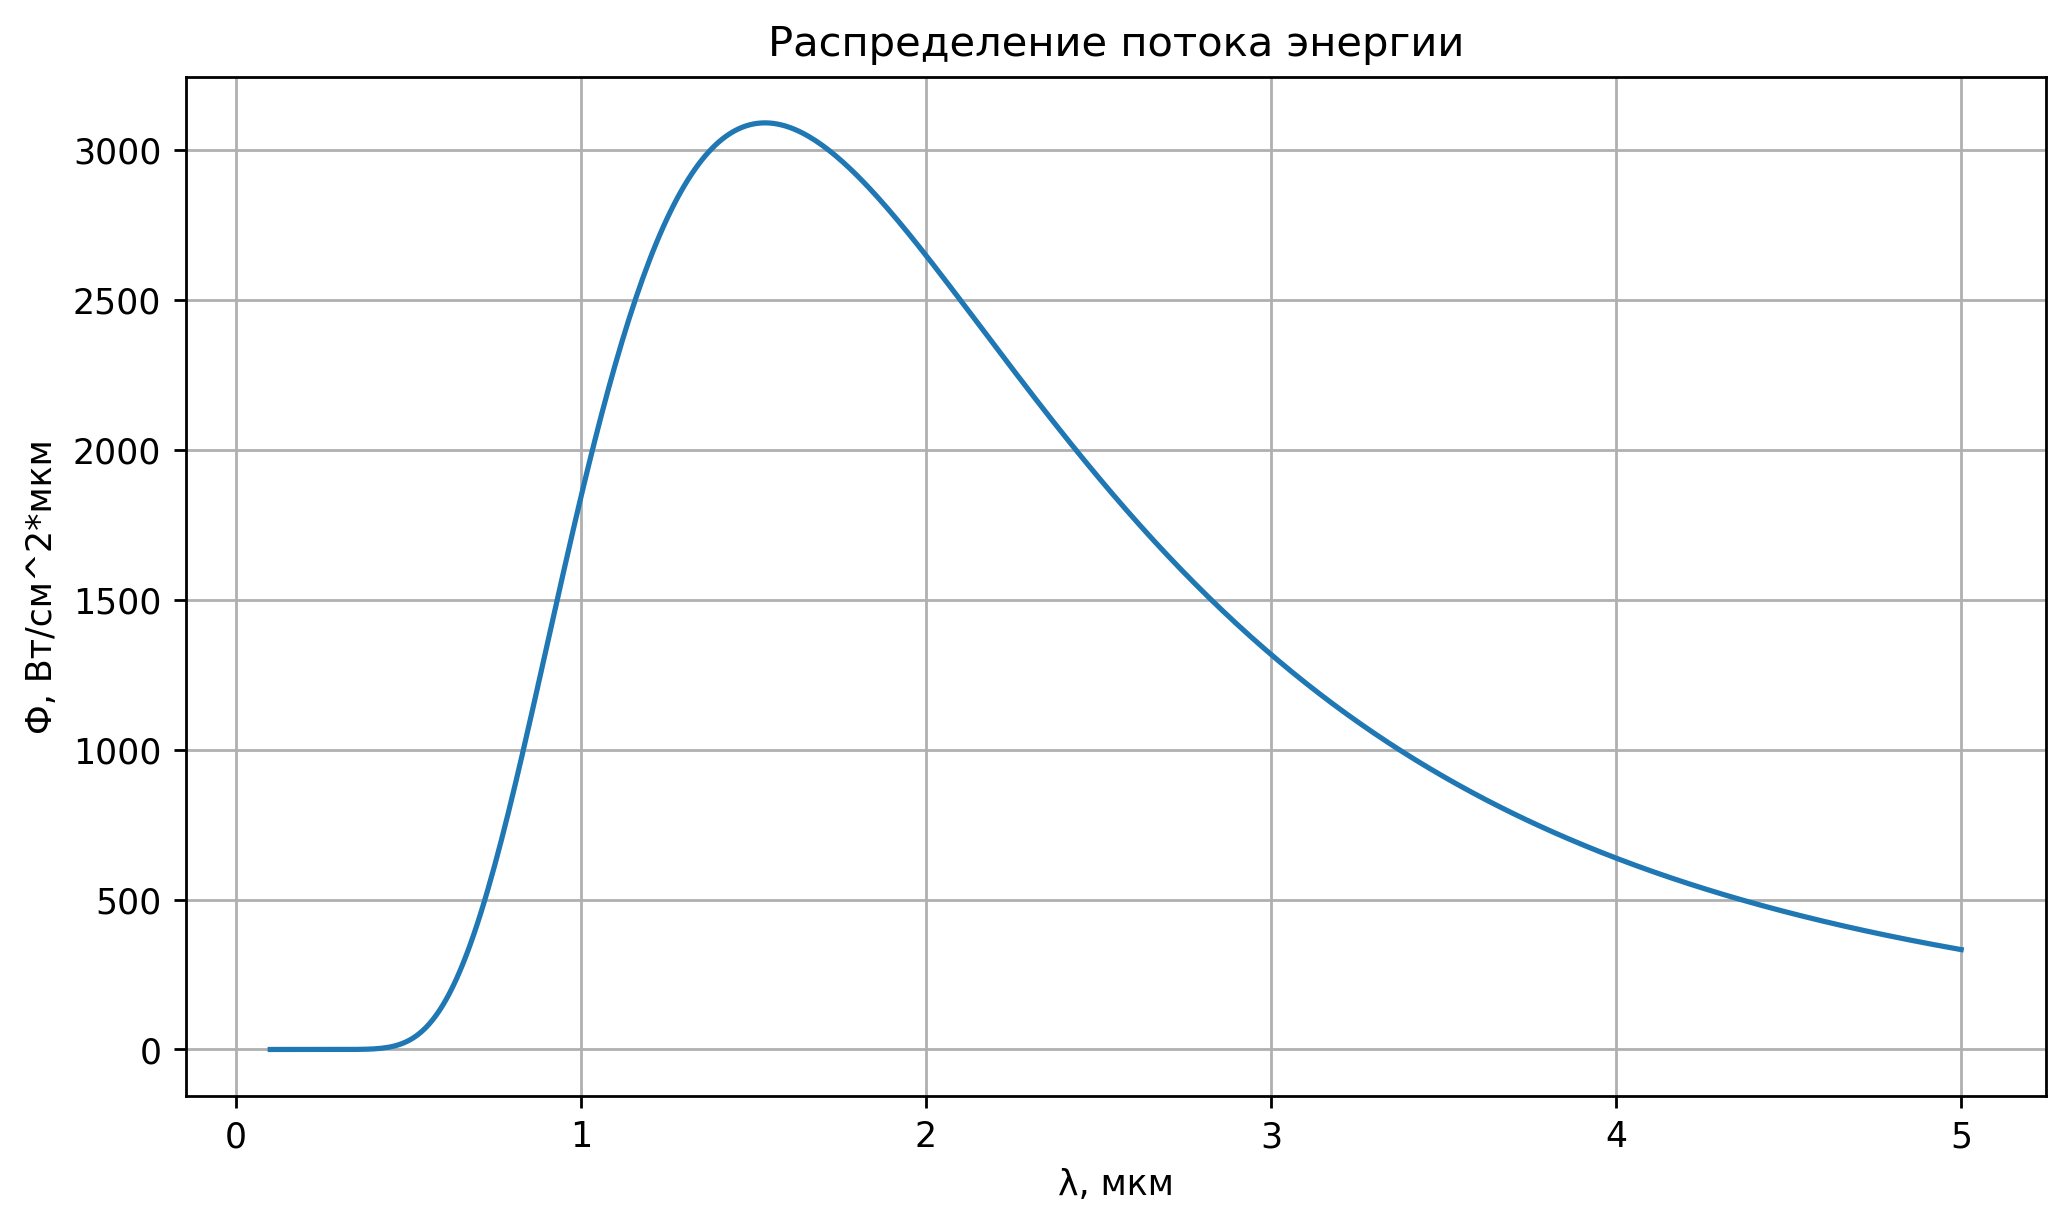

In [6]:
def Ф(lambd):
    Ф = np.zeros(len(lambd))
    for i in range(0, len(lambd)):
        Ф[i] =(2*np.pi*h*c**2/(1e8*lambd[i]**5))*(1/(np.exp((h*c)/(lambd[i]*Tbb*k))-1))
    return Ф

def Fi(lambd):
    Fi =(2*np.pi*h*c**2/(1e8*lambd**5))*(1/(np.exp((h*c)/(lambd*Tbb*k))-1))
    return Fi

print(quad(Fi, 0, inf))
Фpht = Ф(lambd)
fig, ax = plt.subplots()        
plt.rcParams['figure.dpi'] = 250 
plt.rcParams["figure.figsize"] = (9.6,5.4)
plt.rcParams["axes.grid"] = True
ax.set_xlabel("λ, мкм") 
ax.set_ylabel("Ф, Вт/см^2*мкм") 
ax.set_title('Распределение потока энергии')
ax.plot(lambd*1e6, Фpht,);

2.1Построить зависимости коэффициента поглощения от энергии и длины 
волны падающего излучения. 

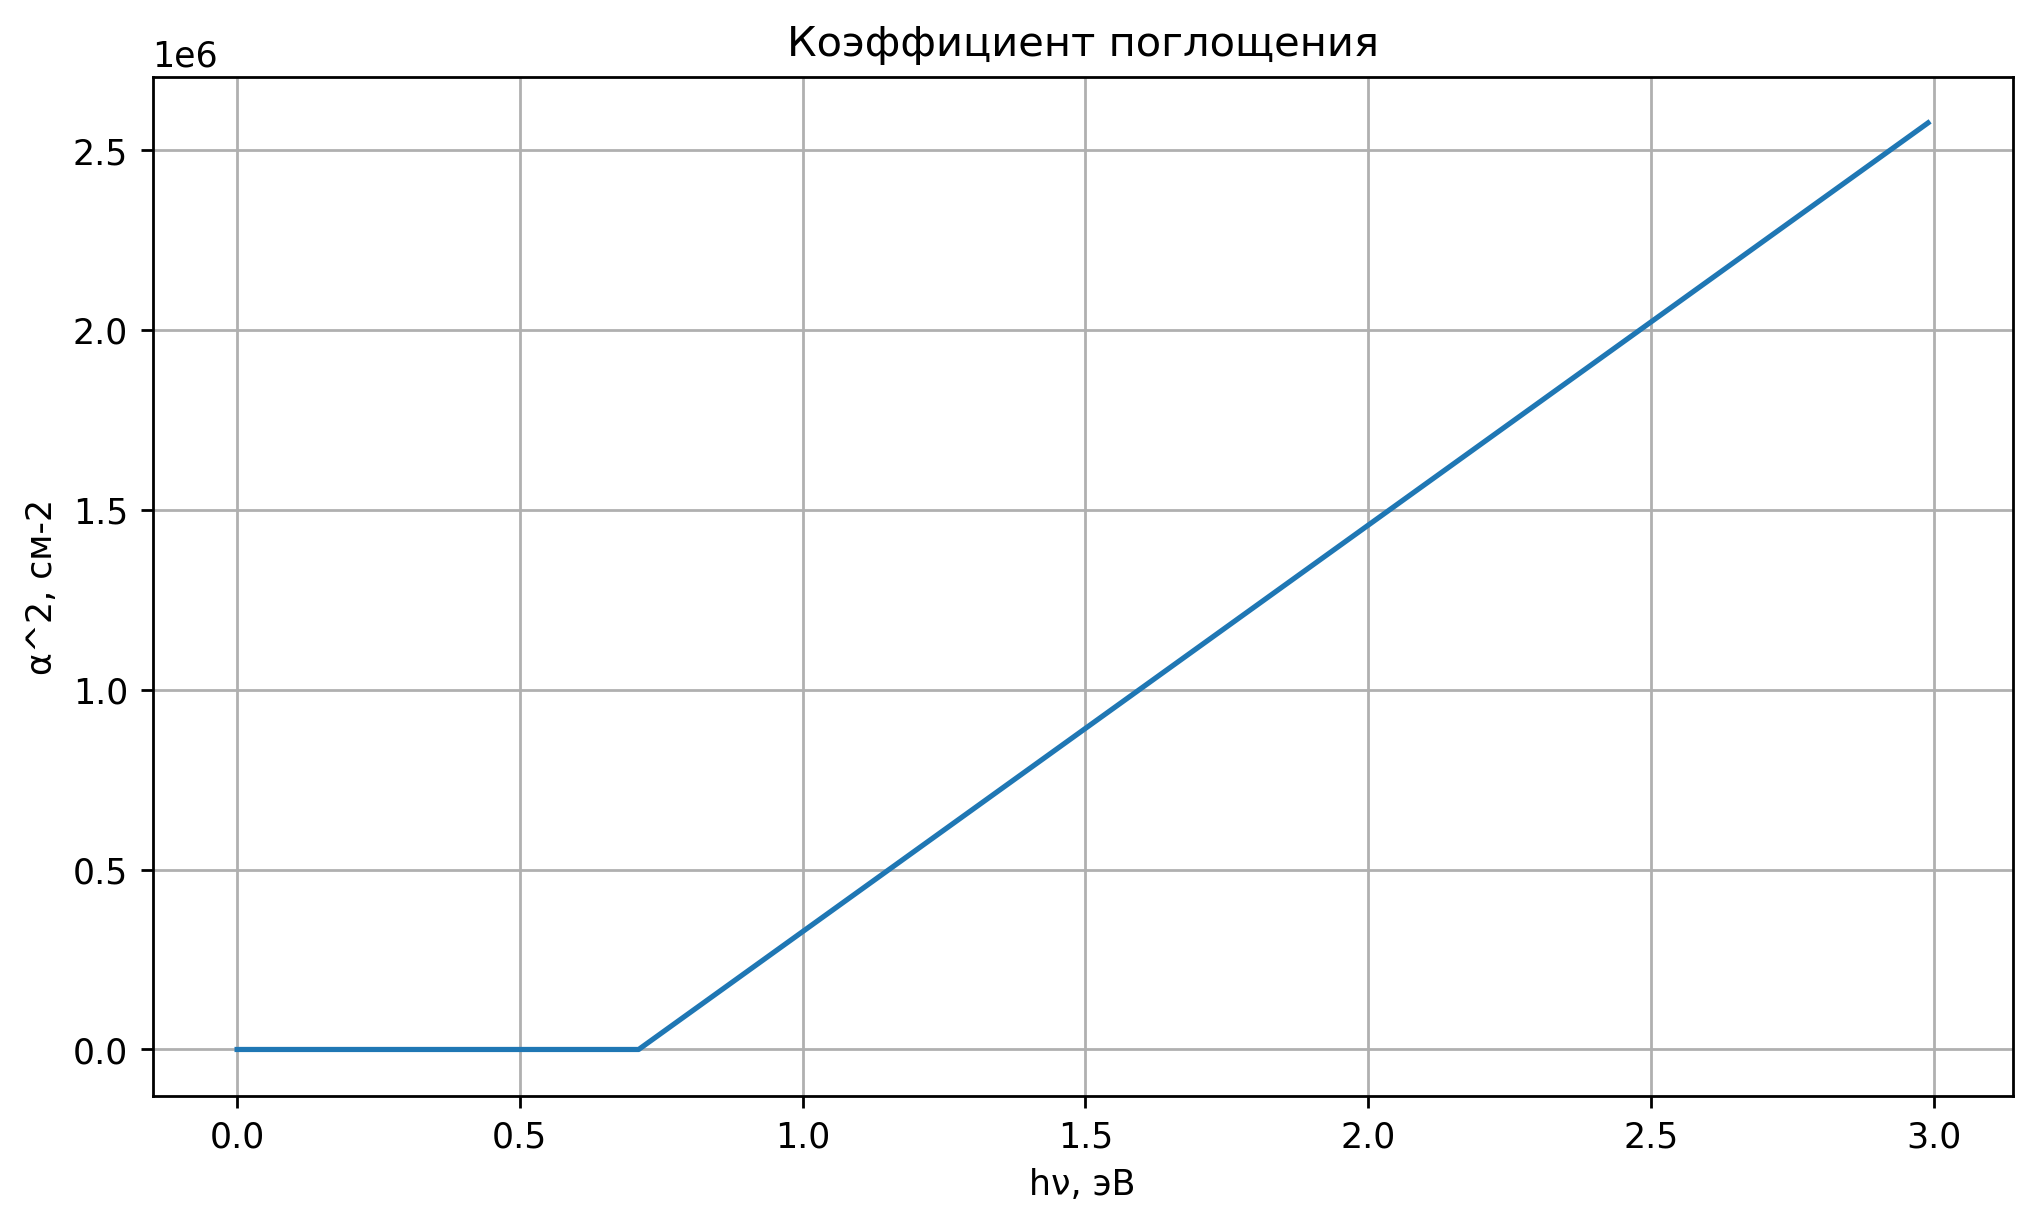

In [23]:
A = (q**2.5*((2*mn*mp)/(mn+mp))**1.5)/(n*c*h**2*mn*ep)
E = np.arange(0, 3, 1e-2)
alpha2 = np.zeros(len(E))

for i in range(0, len(E)):
    if(E[i]<Eg):
        alpha2[i] = 0
    else:
         alpha2[i] =A*(E[i]-Eg)  
    
fig, ax = plt.subplots()        
plt.rcParams['figure.dpi'] = 250 
plt.rcParams["figure.figsize"] = (9.6,5.4)
plt.rcParams["axes.grid"] = True
ax.set_xlabel("hν, эВ") 
ax.set_ylabel("α^2, см-2") 
ax.set_title('Коэффициент поглощения')
ax.plot(E, alpha2);

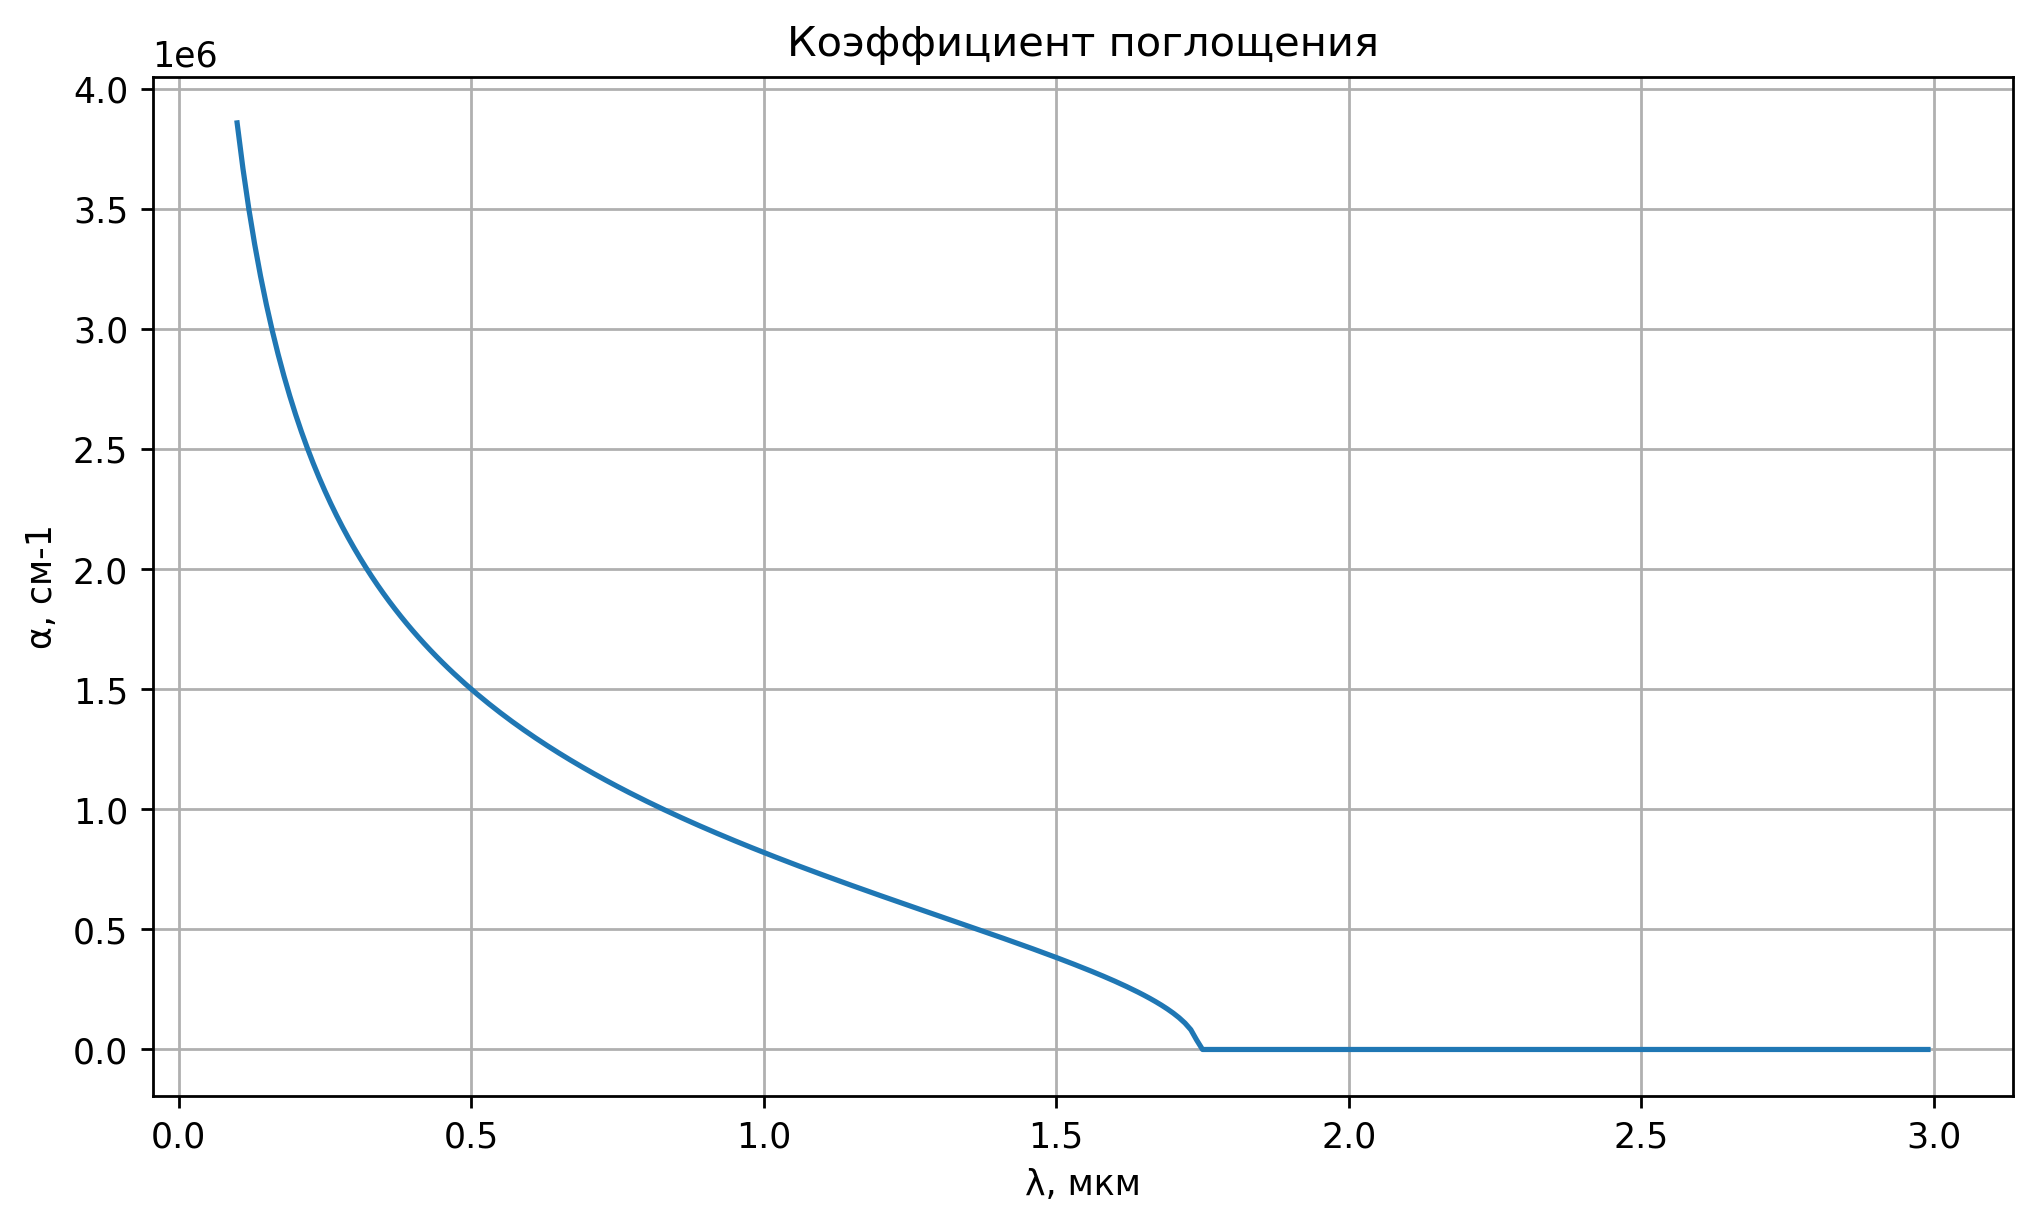

In [30]:
def Alpha(lambd):
    alpha1 = np.zeros(len(lambd))

    for i in range(0, len(lambd)):
        if(h*c/(lambd[i]*q)<Eg):
            alpha1[i] = 0
        else:
            alpha1[i] =A*(h*c/(lambd[i]*q)-Eg)**0.5
    return alpha1
lambd = np.arange(1e-7, 3e-6, 1e-8)


alp=Alpha(lambd)
          
fig, ax = plt.subplots()        
plt.rcParams['figure.dpi'] = 250 
plt.rcParams["figure.figsize"] = (9.6,5.4)
plt.rcParams["axes.grid"] = True
ax.set_xlabel("λ, мкм") 
ax.set_ylabel("α, см-1") 
ax.set_title('Коэффициент поглощения')
ax.plot(lambd*1e6, alp);


2.2 Определить границы длин волн, в которых преобладает равномерное и неравномерное поглощение.
αкр=1/d=300.Значит границы равномерного поглащения лежат в пределах от 1.72 до 1.74 мкм. Неравномерное поглащение наблюдается при длинах волн меньше 1.72 мкм.


2.3 Рассчитать среднюю скорость генерации носителей для различного типа 
поглощения;


Сначала расчитаем скорость генерации для равномерного поглащения

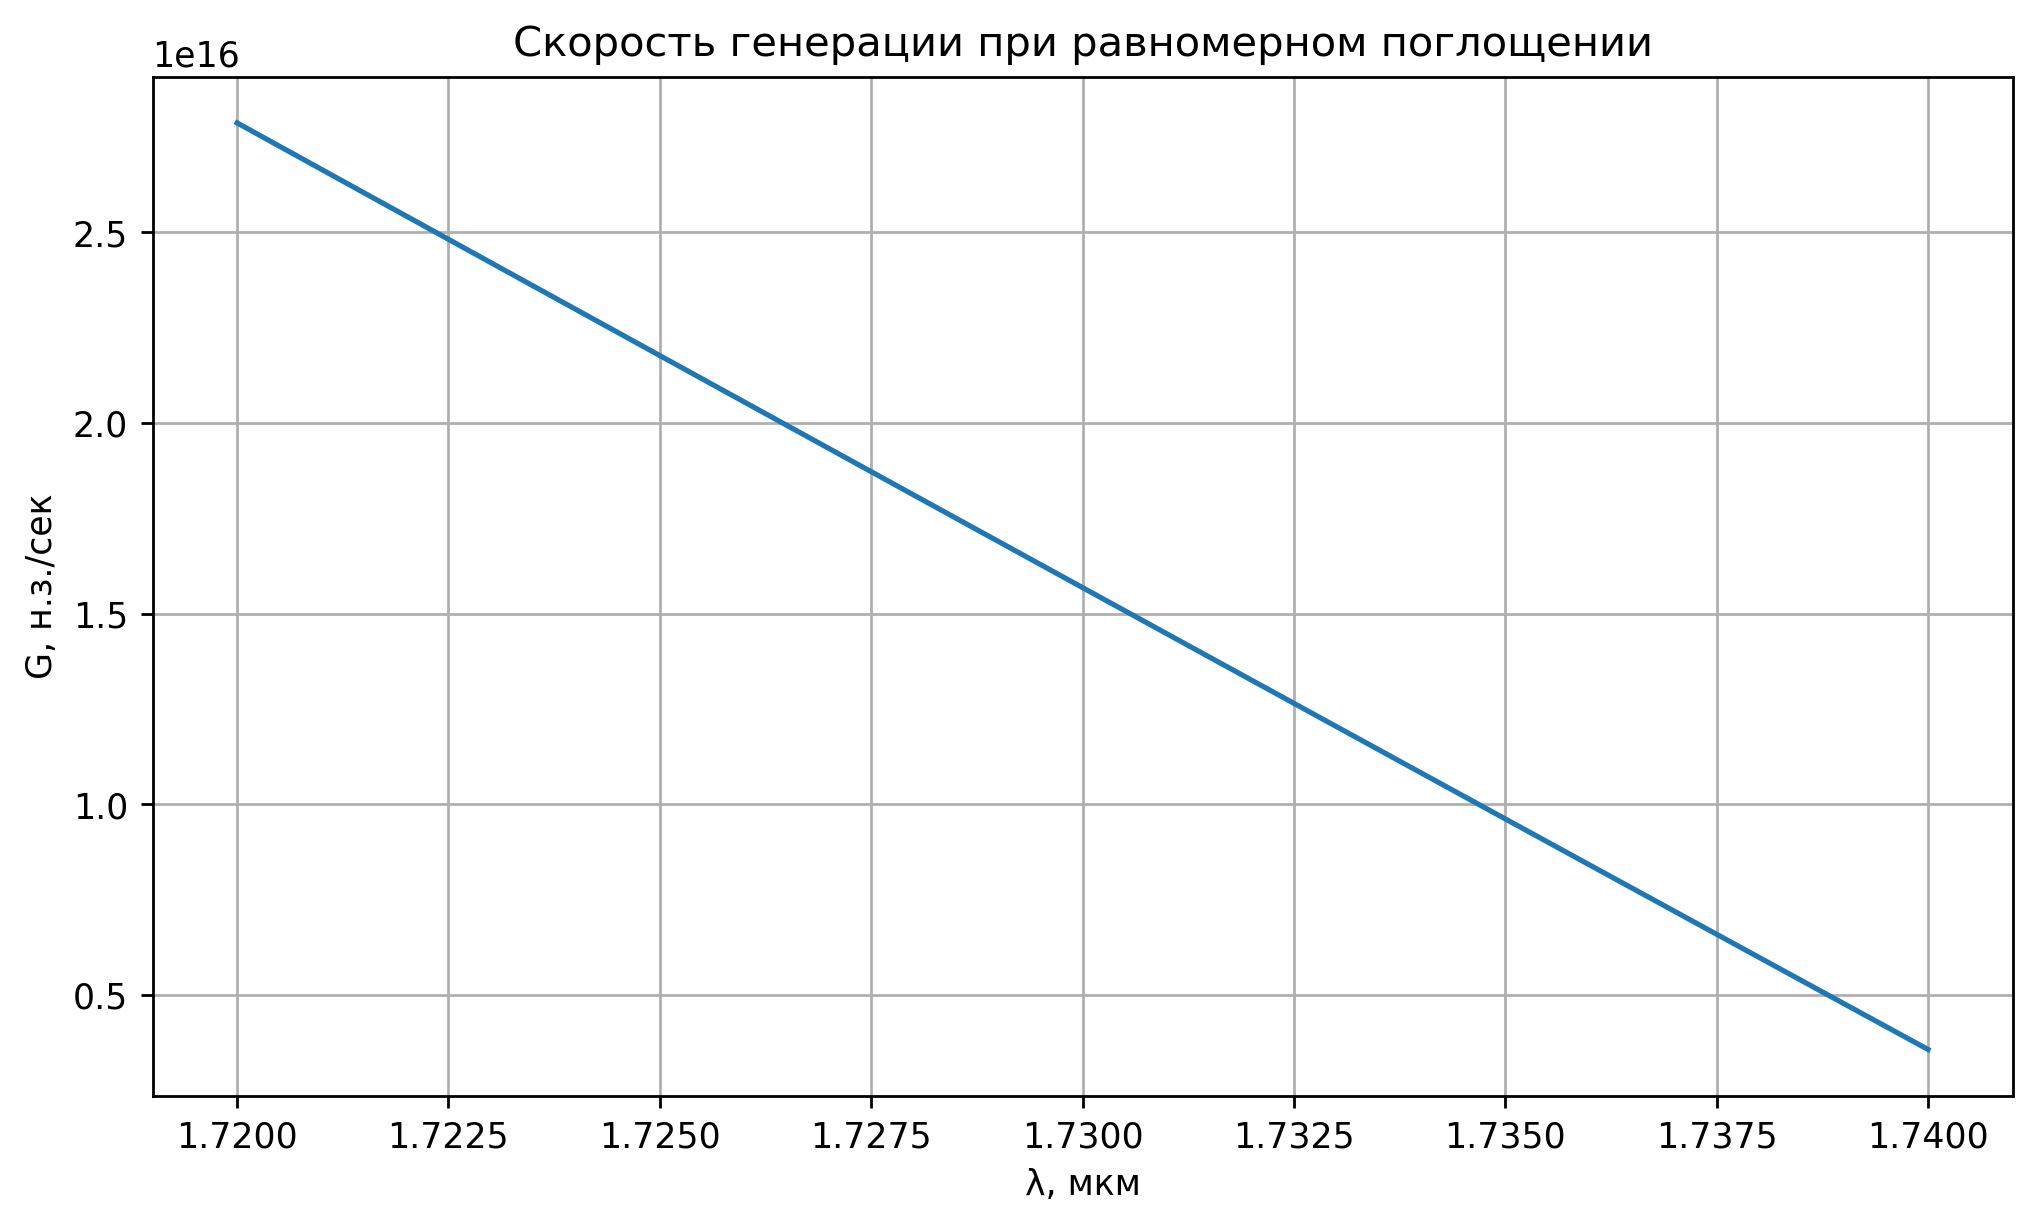

In [26]:
def G(lambd):
    G=np.zeros(len(lambd))
    for i in range(0, len(lambd)):
        G[i]=(N(lambd)[i])*(Alpha(lambd)[i])
    return G
        
lambd1=np.arange(1.72e-6, 1.74e-6, 1e-9)
G1=G(lambd1)  
fig, ax = plt.subplots()        
plt.rcParams['figure.dpi'] = 250 
plt.rcParams["figure.figsize"] = (9.6,5.4)
plt.rcParams["axes.grid"] = True
ax.set_xlabel("λ, мкм") 
ax.set_ylabel("G, н.з./сек") 
ax.set_title('Скорость генерации при равномерном поглощении')
ax.plot(lambd1*1e6, G1);

Расчитаем скорость генерации для неравномерного поглащения

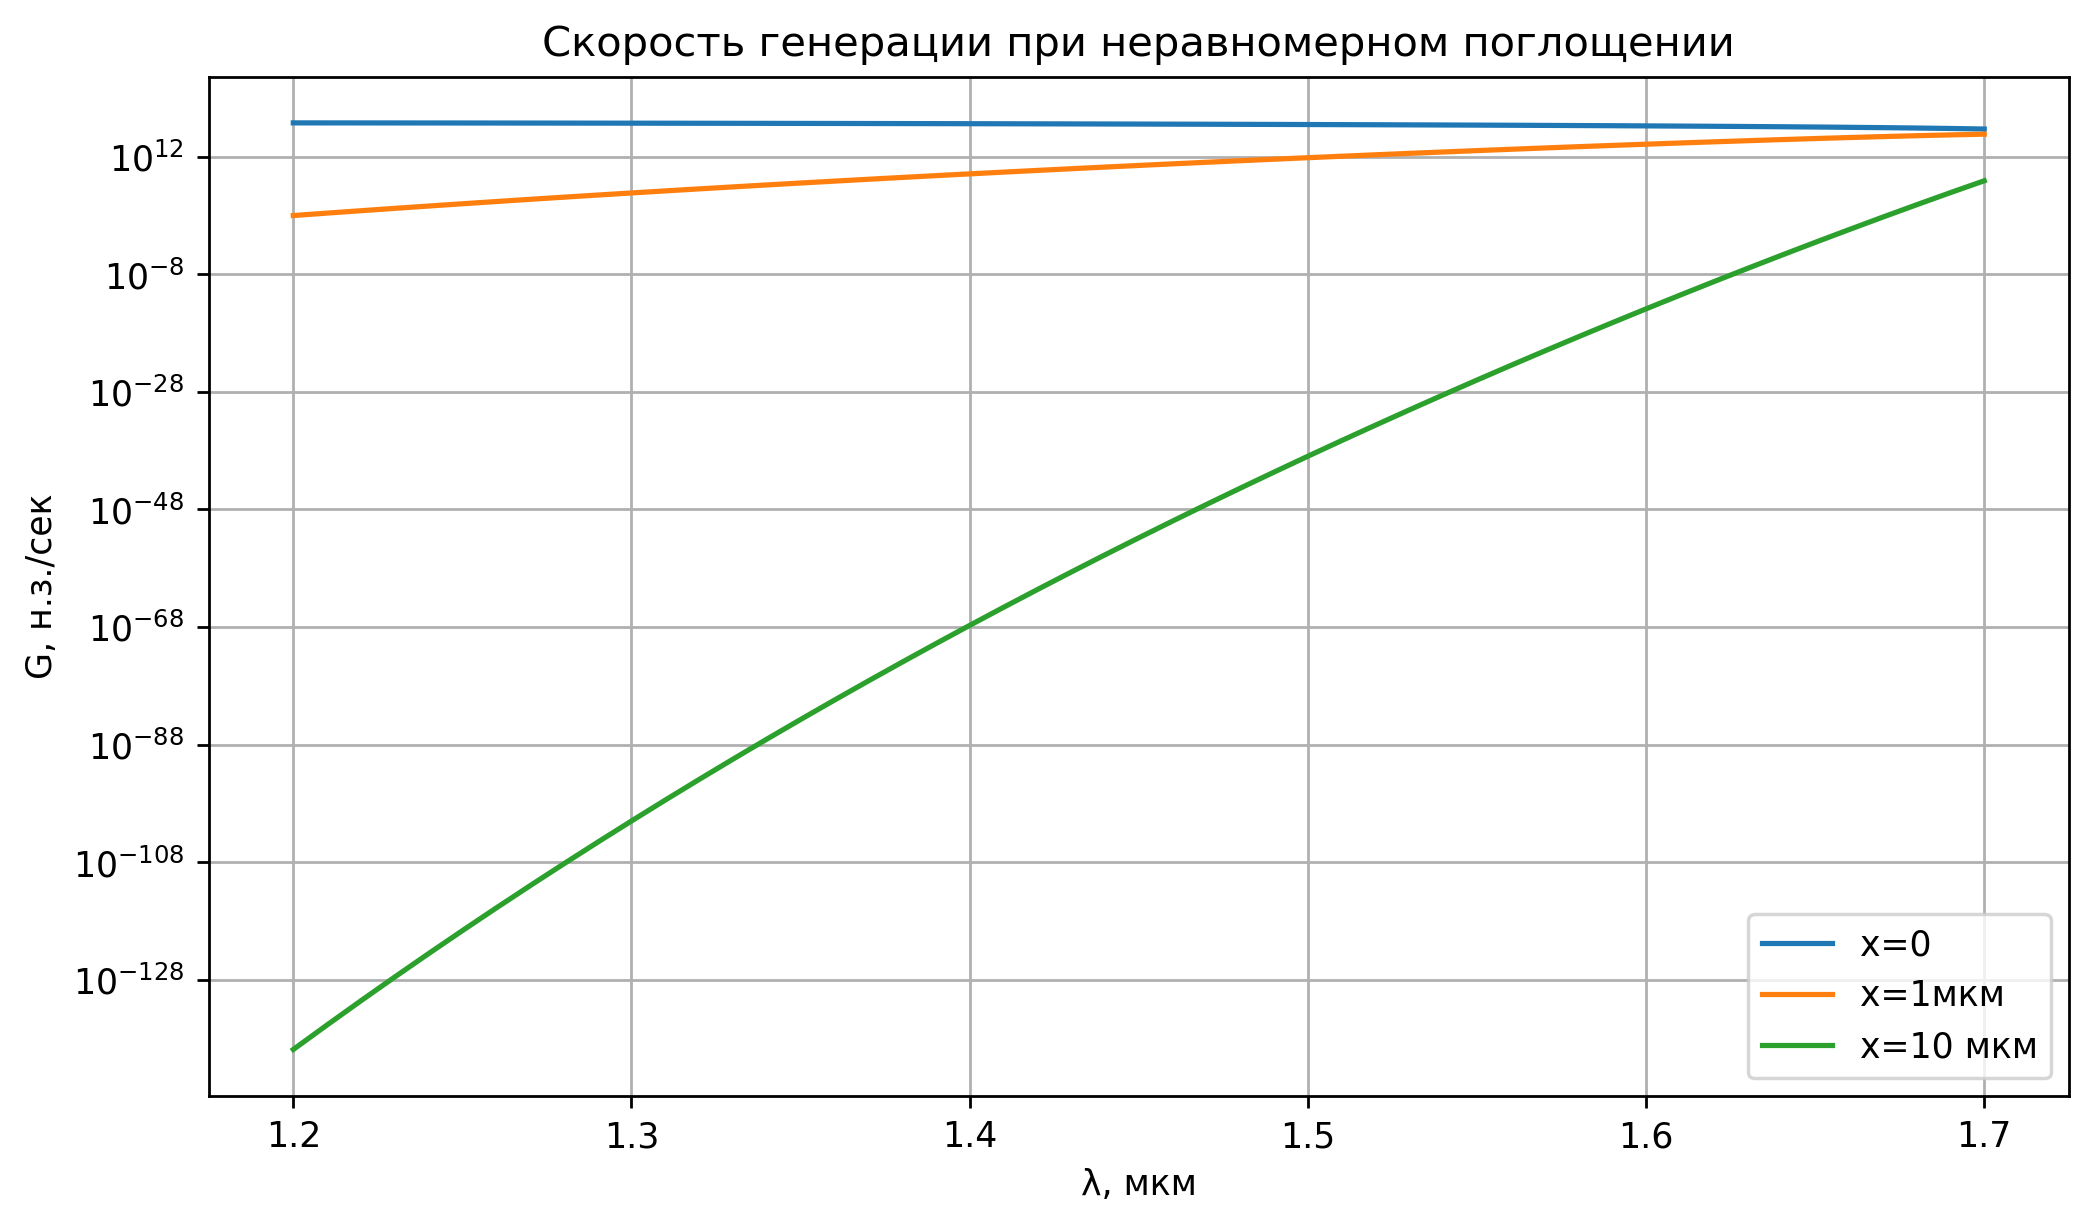

In [27]:
def Gn(lambd,x):
    Gn=np.zeros(len(lambd))
    for i in range(0, len(lambd)):
        Gn[i]=(N(lambd)[i])*(Alpha(lambd)[i])*np.exp(-((Alpha(lambd)[i])*x))
    return Gn

def Gn1(lambd):
    Gn1=(2*np.pi*c/(1e18*lambd**4))*(1/(np.exp((h*c)/(lambd*Tbb*k))-1))*A*(h*c/(lambd*q)-Eg)**0.5
    return Gn1


lambd2=np.arange(1.2e-6, 1.7e-6, 1e-8)
G2=Gn(lambd2,0)  
G3=Gn(lambd2,1e-4)  
G4=Gn(lambd2,1e-3)  
fig, ax = plt.subplots()        
plt.rcParams['figure.dpi'] = 250 
plt.rcParams["figure.figsize"] = (9.6,5.4)
plt.rcParams["axes.grid"] = True
ax.set_xlabel("λ, мкм") 
ax.set_ylabel("G, н.з./сек") 
ax.set_title('Скорость генерации при неравномерном поглощении')
ax.set_yscale('log')
ax.plot(lambd2*1e6, G2,lambd2*1e6,G3,lambd2*1e6,G4);
ax.legend(labels = ("x=0","x=1мкм","x=10 мкм"), loc="best");

Рассчитать и построить зависимости эффективного времени жизни (для 
двух типов поглощения) от скорости поверхностной рекомбинации;

Время жизни для равномерного поглащения

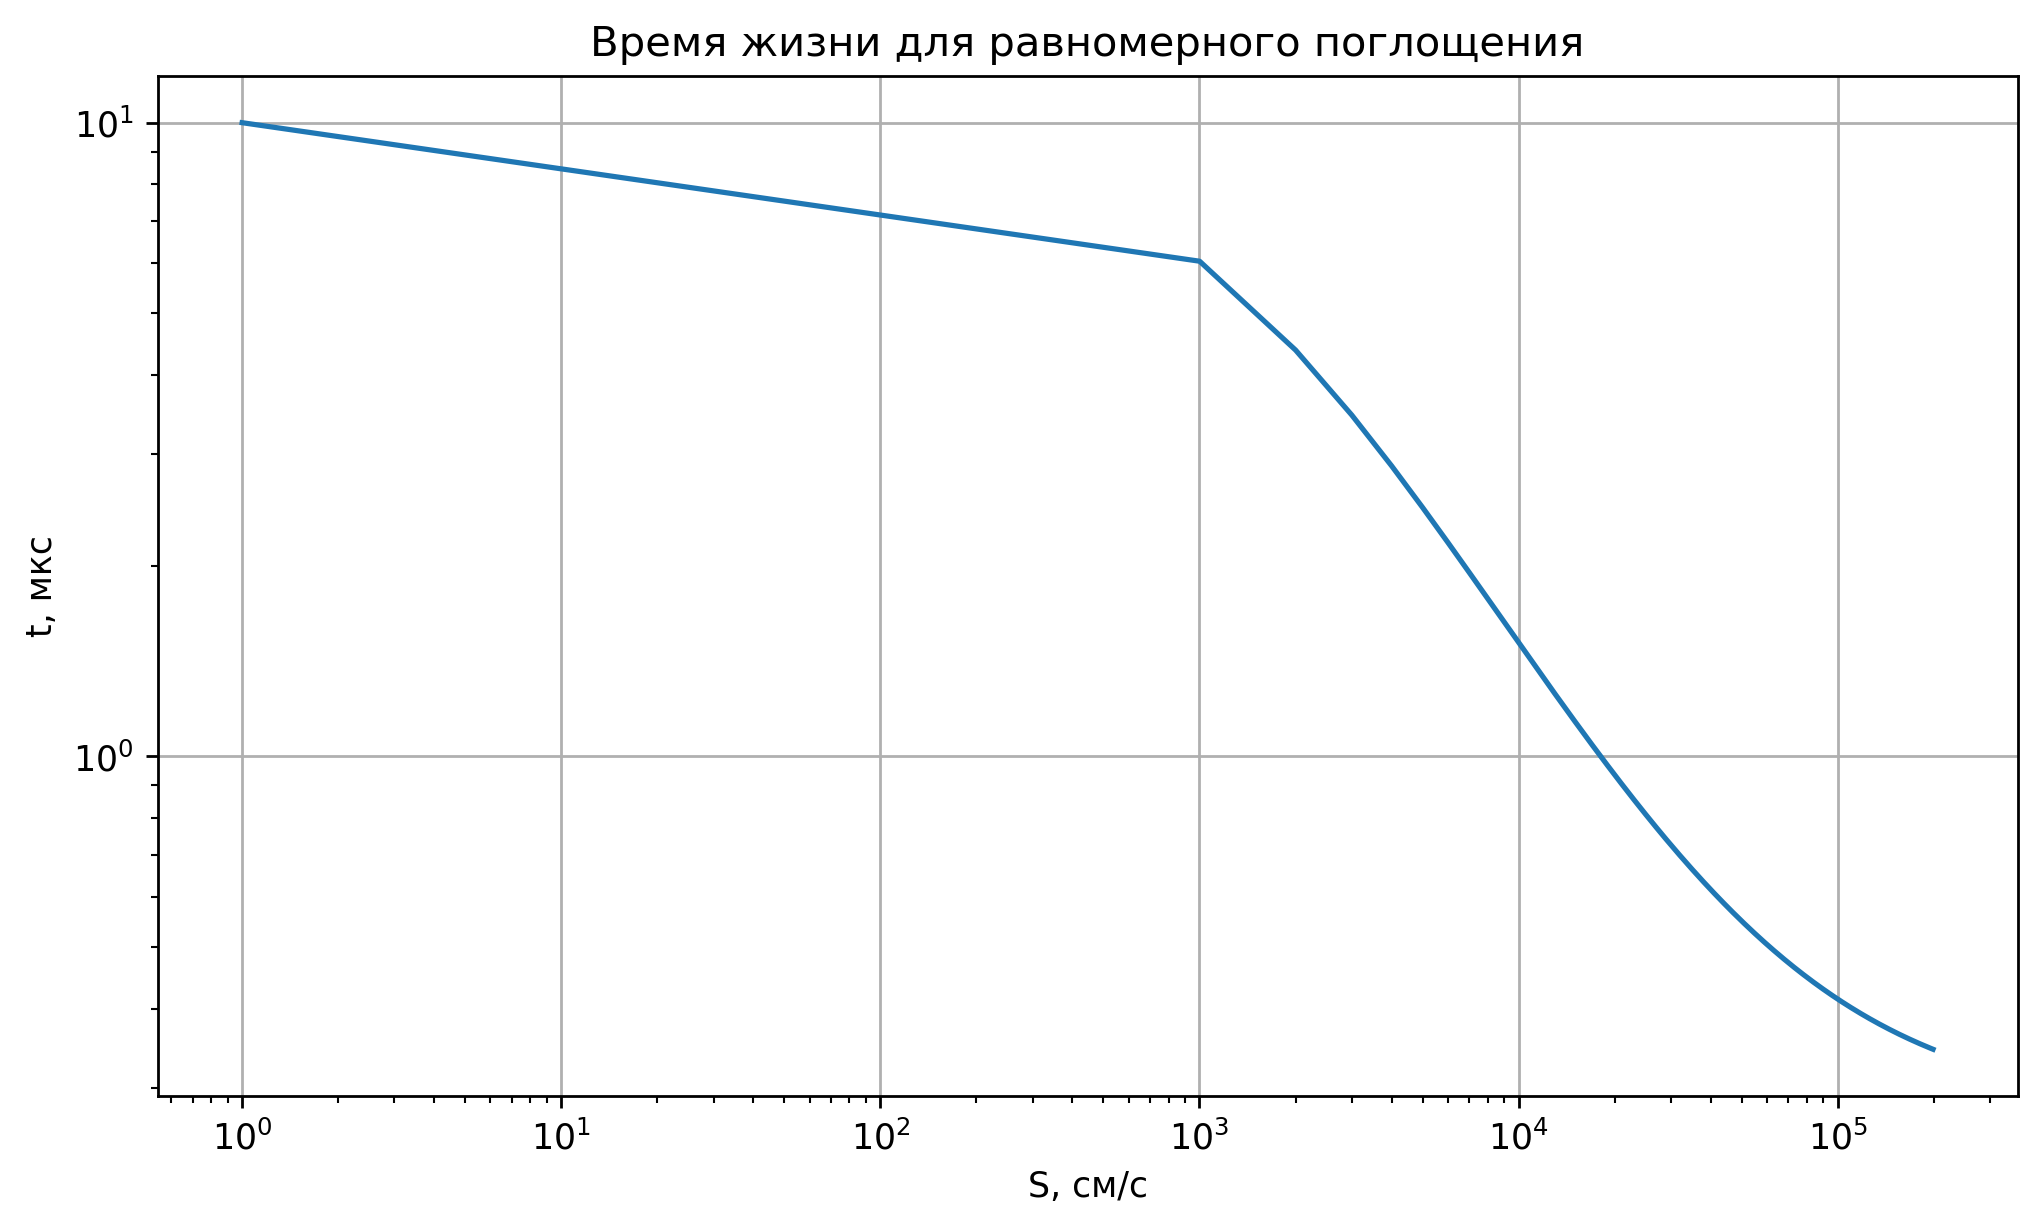

In [36]:
Dp=k*Tpr*up/q
Lp=np.sqrt(t*Dp)

t1 = np.zeros(200)
S = np.arange(1, 2e5, 1e3)
for i in range(0, 200):
    t1[i] =t*(1-(2*S[i]*Lp*np.sinh(d/(2*Lp))/d)/((Dp/Lp)*np.sinh(d/(2*Lp))+S[i]*np.cosh(d/(2*Lp))))
fig, ax = plt.subplots()        
plt.rcParams['figure.dpi'] = 250 
plt.rcParams["figure.figsize"] = (9.6,5.4)
plt.rcParams["axes.grid"] = True
ax.set_xlabel("S, см/с") 
ax.set_ylabel("t, мкс") 
ax.set_title('Время жизни для равномерного поглощения')
ax.plot(S, t1*1e6);
ax.set_xscale('log')
ax.set_yscale('log')

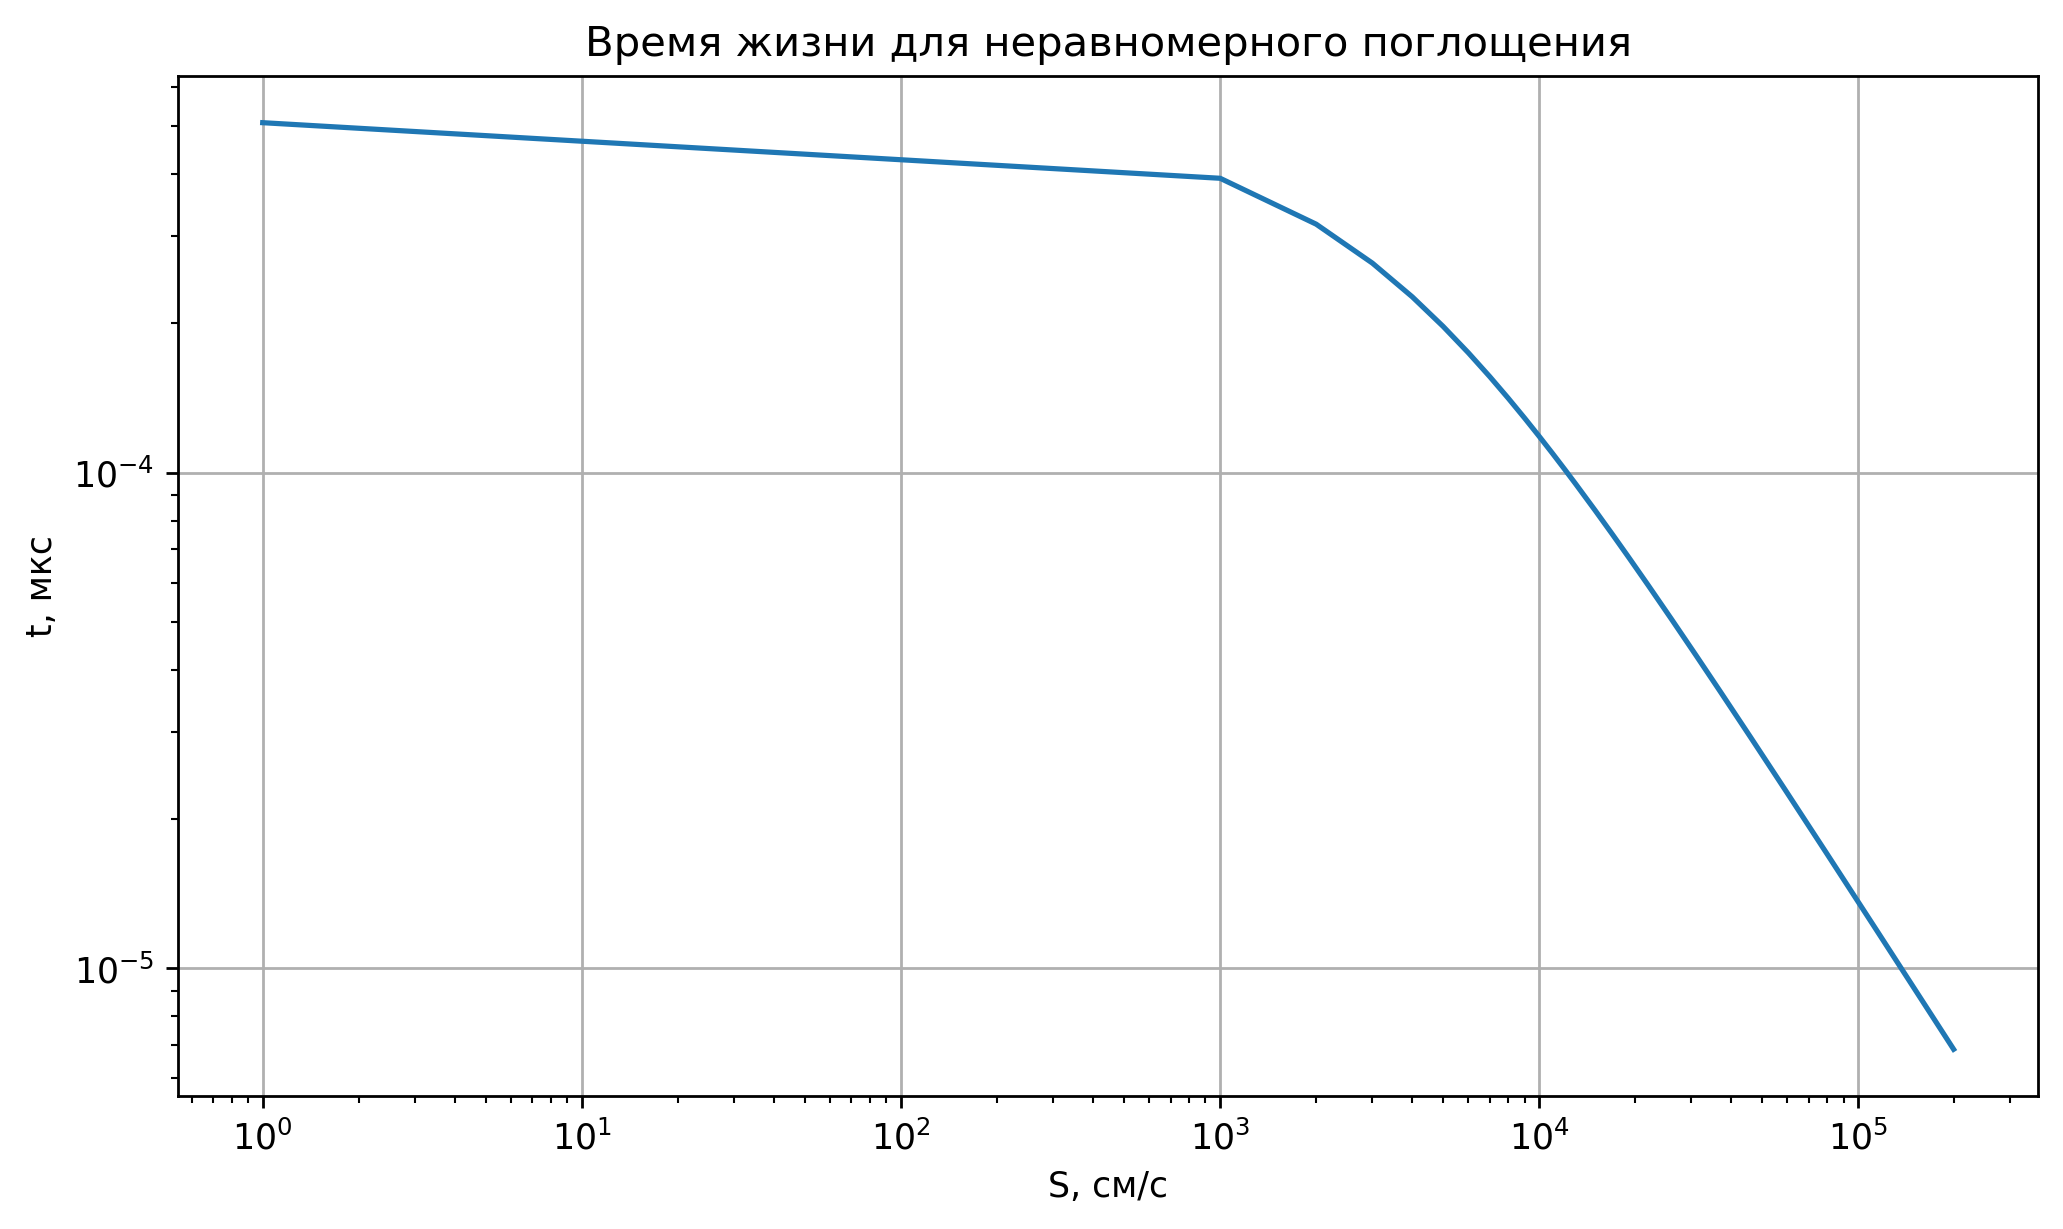

In [35]:

def tef(S,lambd,x):
    tef=np.zeros(len(S))
    for i in range(0, len(S)):
        tef[i]=t/Alpha(lambd)*(t*S[i]*np.sinh((d-x)/Lp)+Lp*np.cosh((d-x)/Lp))/((Lp**2+t**2*(S[i])**2)*np.cosh(d/Lp)+2*Lp*t*S[i]*np.cosh(d/Lp))
    return tef

t2 = tef(S,[1.5e-6],0)

fig, ax = plt.subplots()        
plt.rcParams['figure.dpi'] = 250 
plt.rcParams["figure.figsize"] = (9.6,5.4)
plt.rcParams["axes.grid"] = True
ax.set_xlabel("S, см/с") 
ax.set_ylabel("t, мкс") 
ax.set_title('Время жизни для неравномерного поглощения')
ax.plot(S, t2*1e6);
ax.set_xscale('log')
ax.set_yscale('log')

2.5  Рассчитать  сопротивление  ФР  при  наличии  падающего  излучения, рассчитать во сколько раз оно отличается от темнового;


In [13]:
Gg=(quad(Gn1, 1e-7, 1.74e-6))
ng=Gn([1.45e-6],0)*tef([Su],[1.5e-6],0) 
Rs0 = 1/(ng*q*(un+up))*1/d
Rs='%.2f'%Rs0
r=Rt/Rs0/1e11
print("Сопротивление при наличии падающего излучения",Rs,"Ом")
print("Разница между темновым и световым сопротивление",'%.2f'%r,'*1e11')

Сопротивление при наличии падающего излучения 203088877.95 Ом
Разница между темновым и световым сопротивление 6.83 *1e11


2.6  Рассчитать и построить световую ВАХ ФР;

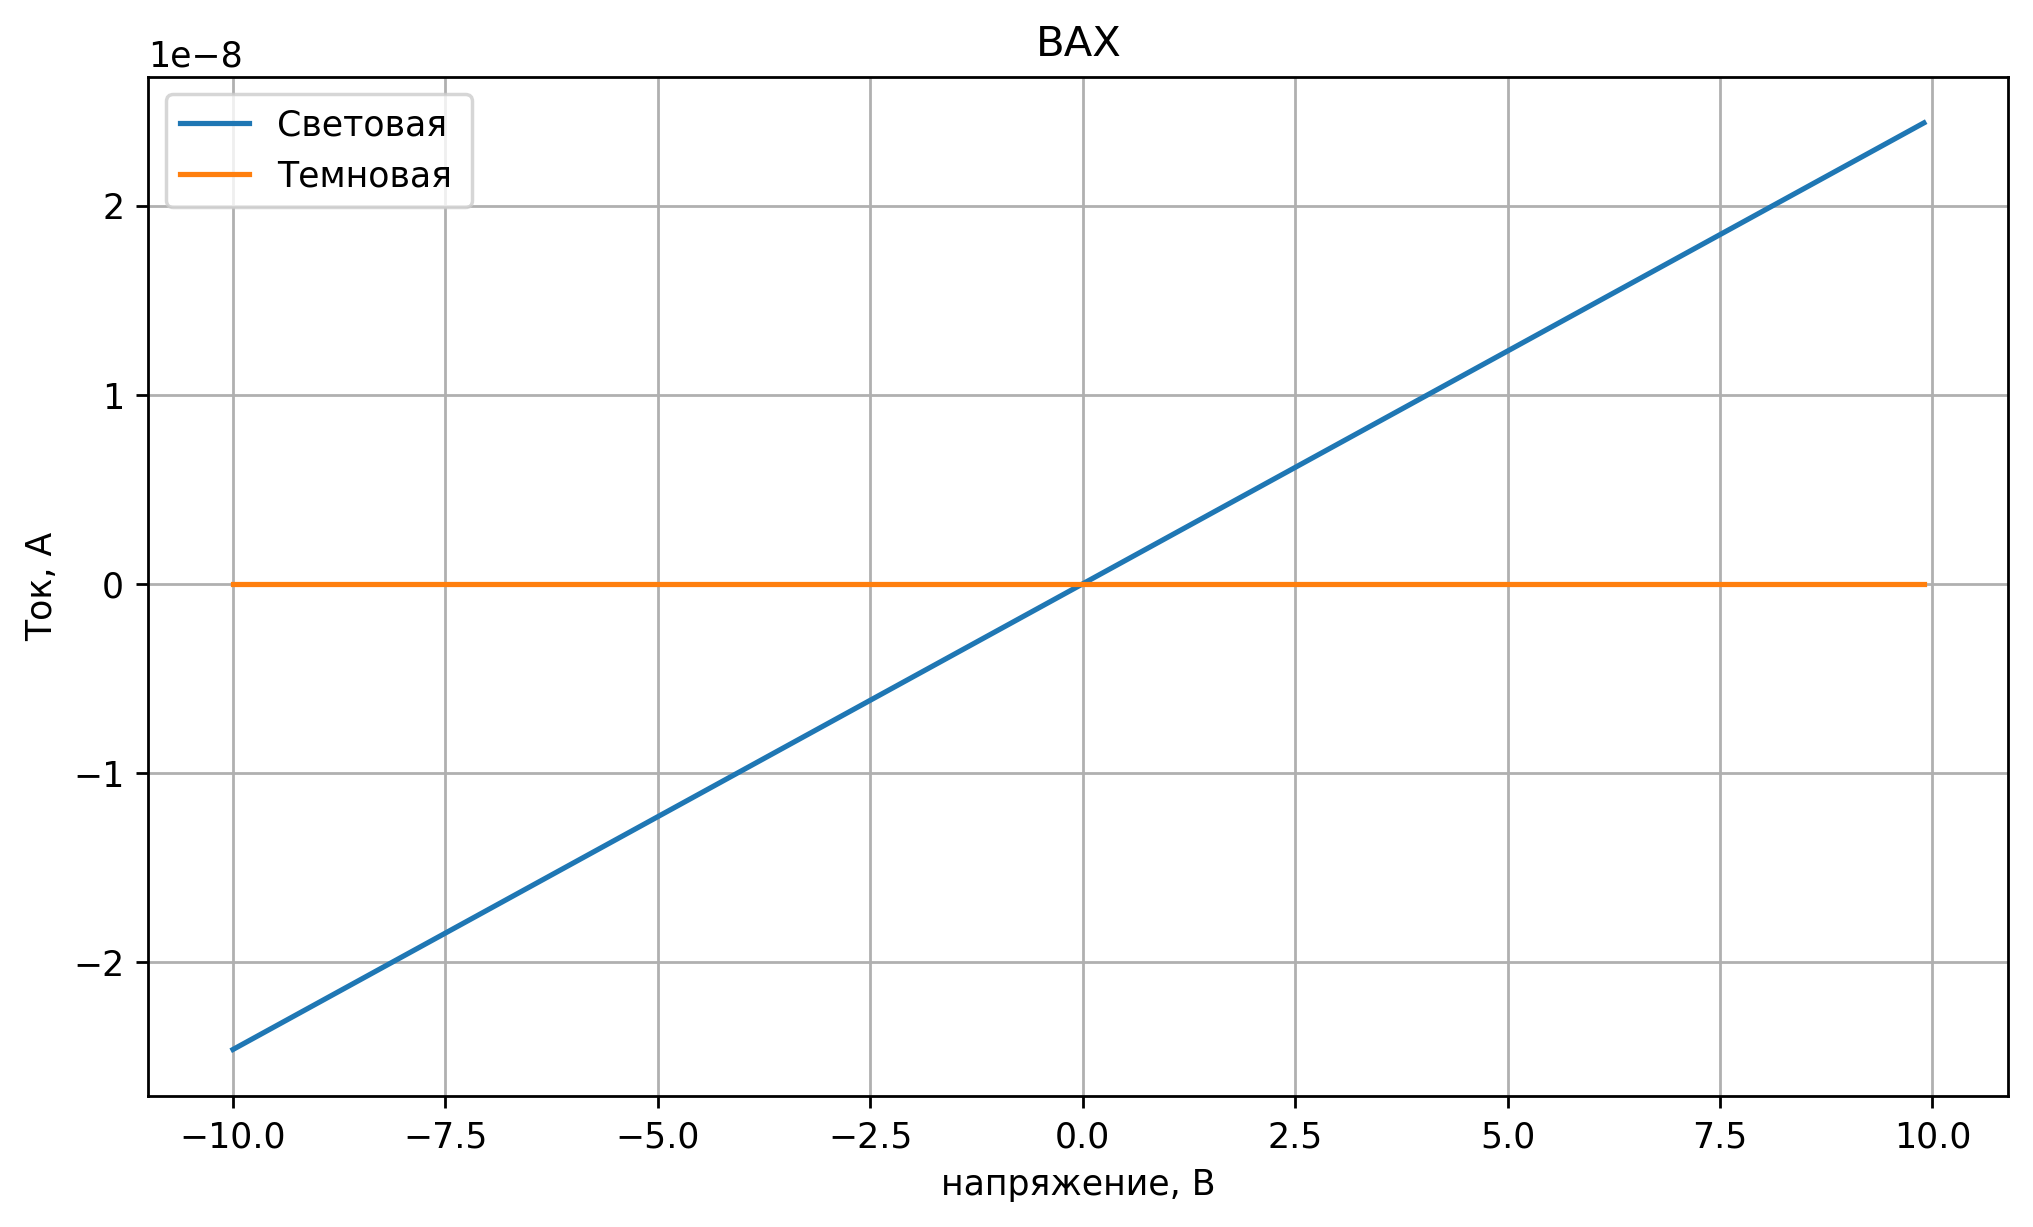

In [14]:
Iphs = np.zeros(200)
for i in range(0, 200):
    Iphs[i] = V0[i]/(2*Rs0);
 
fig, ax = plt.subplots()        
plt.rcParams['figure.dpi'] = 250 
plt.rcParams["figure.figsize"] = (9.6,5.4)
plt.rcParams["axes.grid"] = True
ax.set_xlabel("напряжение, В") 
ax.set_ylabel("Ток, А") 
ax.set_title('ВАХ')
ax.plot(V0, Iphs,V0,Ipht);
ax.legend(labels = ("Световая ","Темновая"), loc="best");

2.7  Рассчитать интегральную чувствительность.

In [15]:
Ss=(Lp*np.sinh(d/Lp)+t*Su*(np.cosh(d/Lp)-1))*(Lp+t*Su)/((Lp**2+t**2*(Su)**2)*np.cosh(d/Lp)+2*Lp*t*Su*np.cosh(d/Lp))

def Si(lambd):
    Si = Ss*q/(h*c)*(A*(h*c/(lambd*q)-Eg)**0.5*lambd)*(tef([Su],[1.5e-6],0)*up*Lp*(1+un/up))/(Lp+Su*tef([Su],[1.5e-6],0))*5*d
    return Si
Sin=quad(Si, 0, 1.74e-6)[0]
print(Sin)




2.4616008184831065e-08


Интегральная чувствительность составила 2.46 10^-8

3.1  Рассчитать  и  построить спектральные зависимости  концентрации 
носителей зарядов от падающего излучения; 

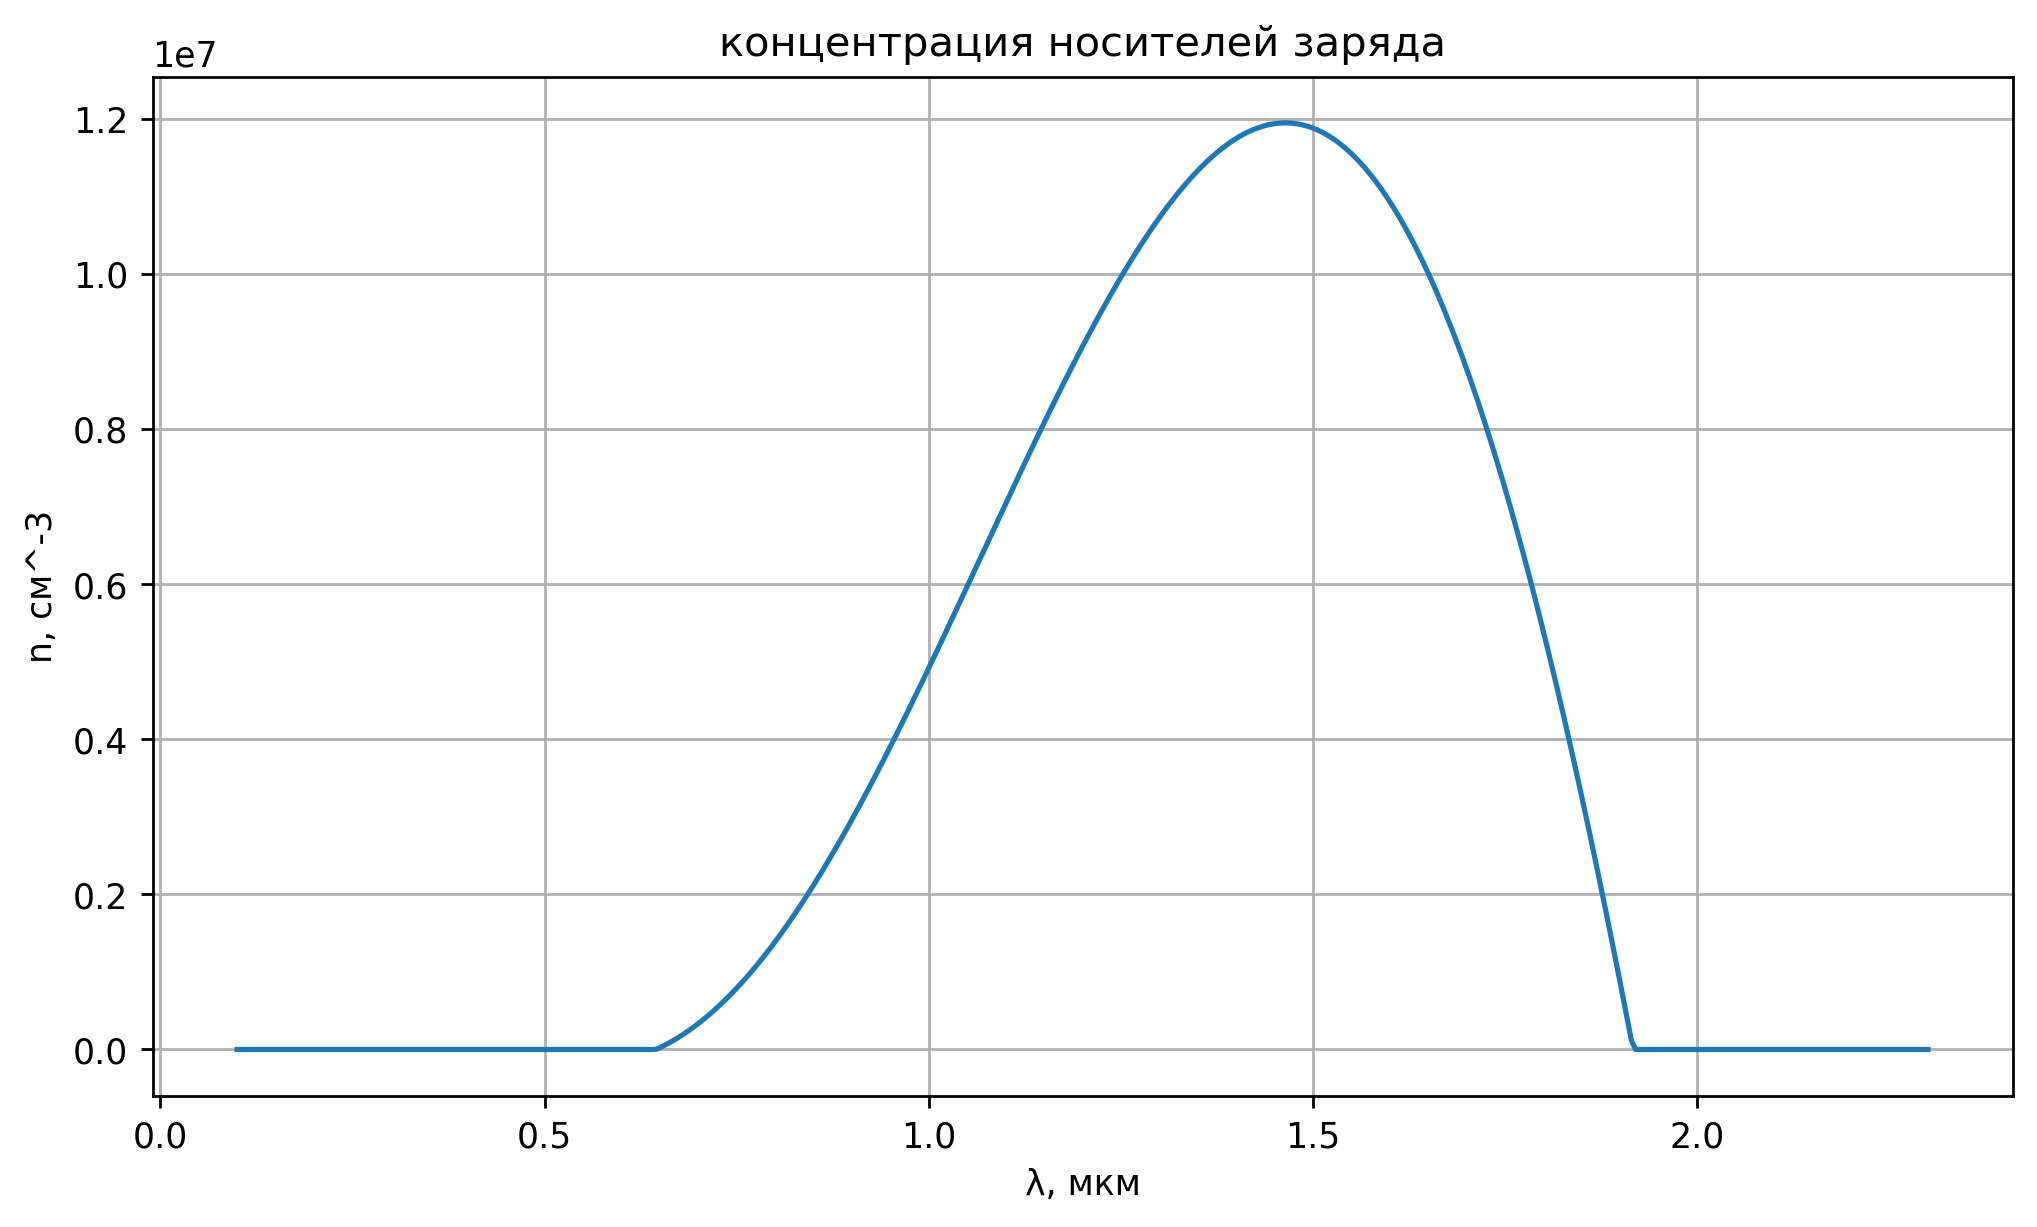

In [16]:
def nd(lambd):
    nd=np.zeros(len(lambd))
    for i in range(0, len(lambd)):
        if(h*c/(lambd[i]*q)<=Eg):
            nd[i] = 0
        else:
            nd[i] =Gn(lambd,0)[i]*t/Alpha(lambd)[i]*(t*Su*np.sinh((d)/Lp)+Lp*np.cosh((d)/Lp))/((Lp**2+t**2*(Su)**2)*np.cosh(d/Lp)+2*Lp*t*Su*np.cosh(d/Lp))
    return nd

lambd3=np.arange(1e-7, 2e-6, 1e-8)
nn =nd(lambd3) 
x = np.linspace(1e-7, 2.3e-6, 400)
y0 = Polynomial.fit(lambd3, nn, 5)
Nn = np.zeros(len(x))
for i in range(0, len(x)):
    if(y0(x)[i]<0)|(x[i]<0.5e-6):
        Nn[i]=0
    else:
        Nn[i]=y0(x)[i]
fig, ax = plt.subplots()        
plt.rcParams['figure.dpi'] = 250 
plt.rcParams["figure.figsize"] = (9.6,5.4)
plt.rcParams["axes.grid"] = True
ax.set_xlabel("λ, мкм") 
ax.set_ylabel("n, см^-3") 
ax.set_title('концентрация носителей заряда')

ax.plot(x*1e6, Nn);


In [17]:
print(nn[164])

13653578.051401637


3.2 Рассчитать и построить зависимости фототока от падающего излучения;

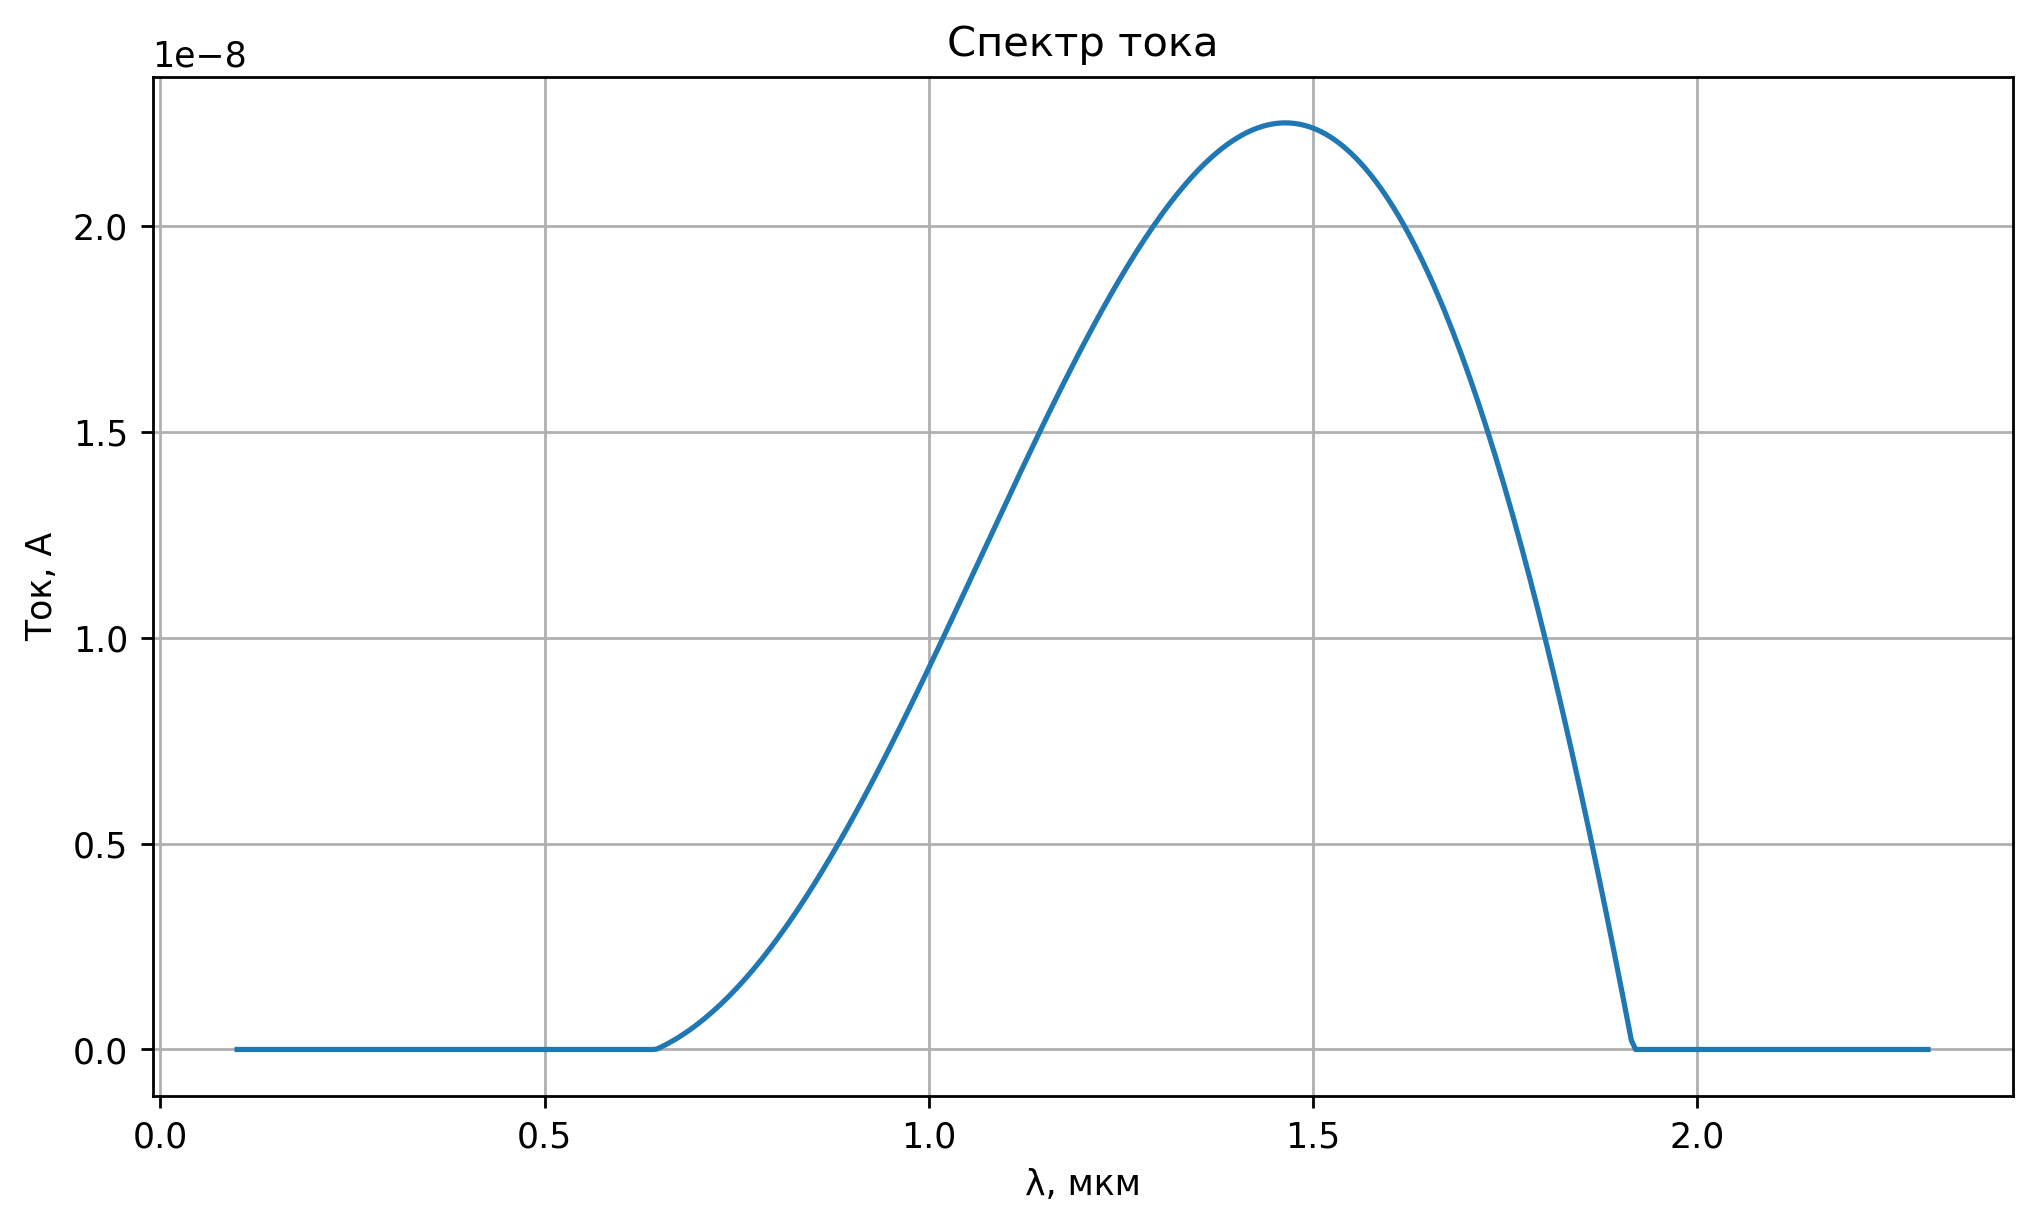

In [18]:
Iph = np.zeros(len(lambd3))
for i in range(0, len(lambd3)):
    Iph[i] = 5*(nn[i]*q*(un+up))*d
x = np.linspace(1e-7, 2.3e-6, 400)
y0 = Polynomial.fit(lambd3, Iph, 5)
Ip = np.zeros(len(x))
for i in range(0, len(x)):
    if(y0(x)[i]<0)|(x[i]<0.5e-6):
        Ip[i]=0
    else:
        Ip[i]=y0(x)[i]
fig, ax = plt.subplots()        
plt.rcParams['figure.dpi'] = 250 
plt.rcParams["figure.figsize"] = (9.6,5.4)
plt.rcParams["axes.grid"] = True
ax.set_xlabel("λ, мкм") 
ax.set_ylabel("Ток, А") 
ax.set_title('Спектр тока')
ax.plot(x*1e6, Ip);


3.3  Рассчитать  и  построить  зависимость  токовой  чувствительности  от 
падающего излучения;

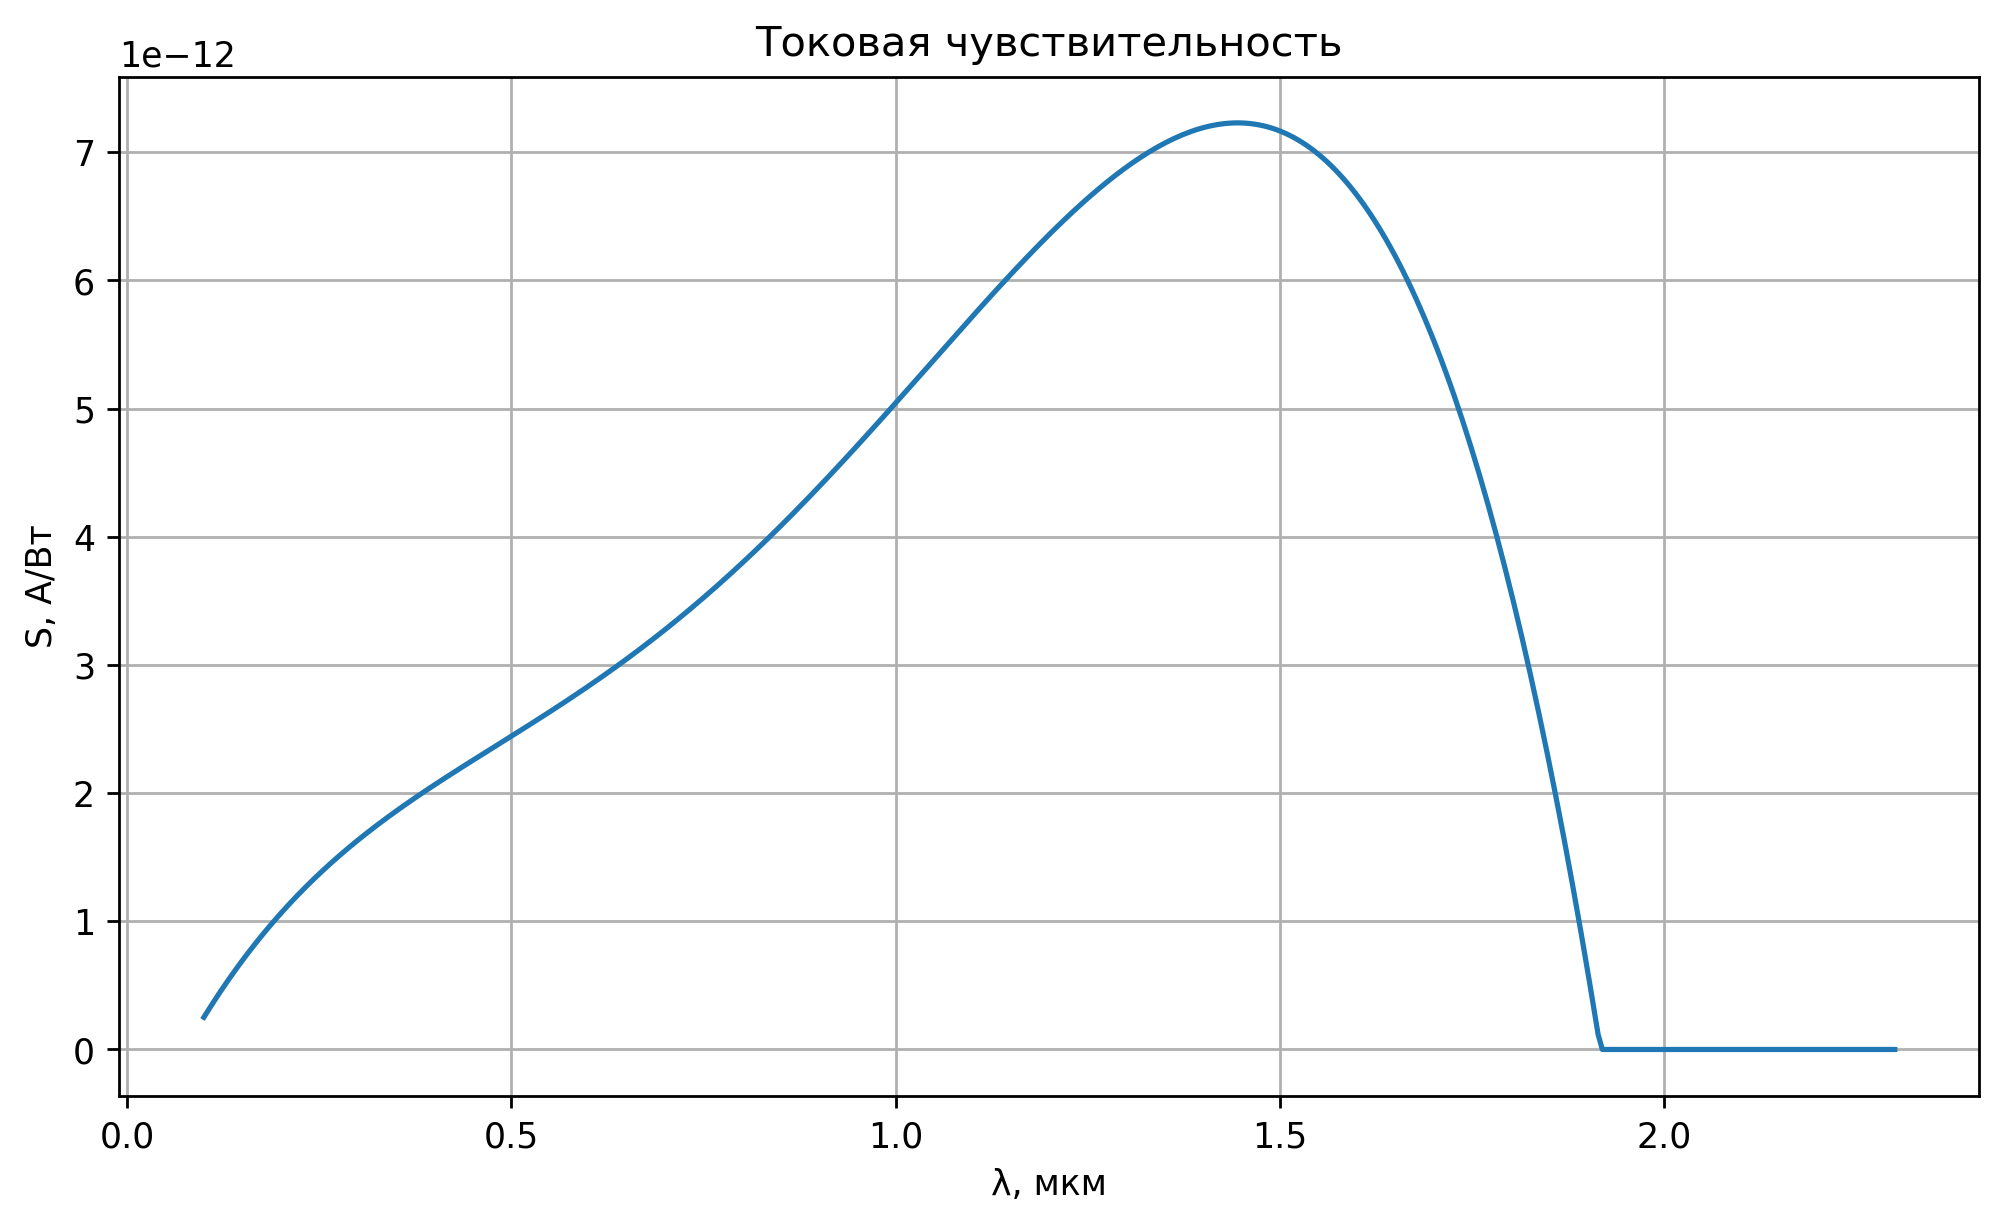

In [19]:
Siph = np.zeros(len(lambd3))
Фi=Ф(lambd3)
for i in range(0, len(lambd3)):
    Siph[i] = Iph[i]/Фi[i];
x = np.linspace(1e-7, 2.3e-6, 400)
y1 = Polynomial.fit(lambd3, Siph, 4)
Sph = np.zeros(len(x))
for i in range(0, len(x)):
    if(y1(x)[i]<0):
        Sph[i]=0
    else:
        Sph[i]=y1(x)[i]

fig, ax = plt.subplots()        
plt.rcParams['figure.dpi'] = 250 
plt.rcParams["figure.figsize"] = (9.6,5.4)
plt.rcParams["axes.grid"] = True
ax.set_xlabel("λ, мкм") 
ax.set_ylabel("S, А/Вт") 
ax.set_title('Токовая чувствительность')
ax.plot(x*1e6, Sph);


3.4 Приняв,  ГРШ  как  основной  шум,  рассчитать  интегральную 
обнаружительную способность.

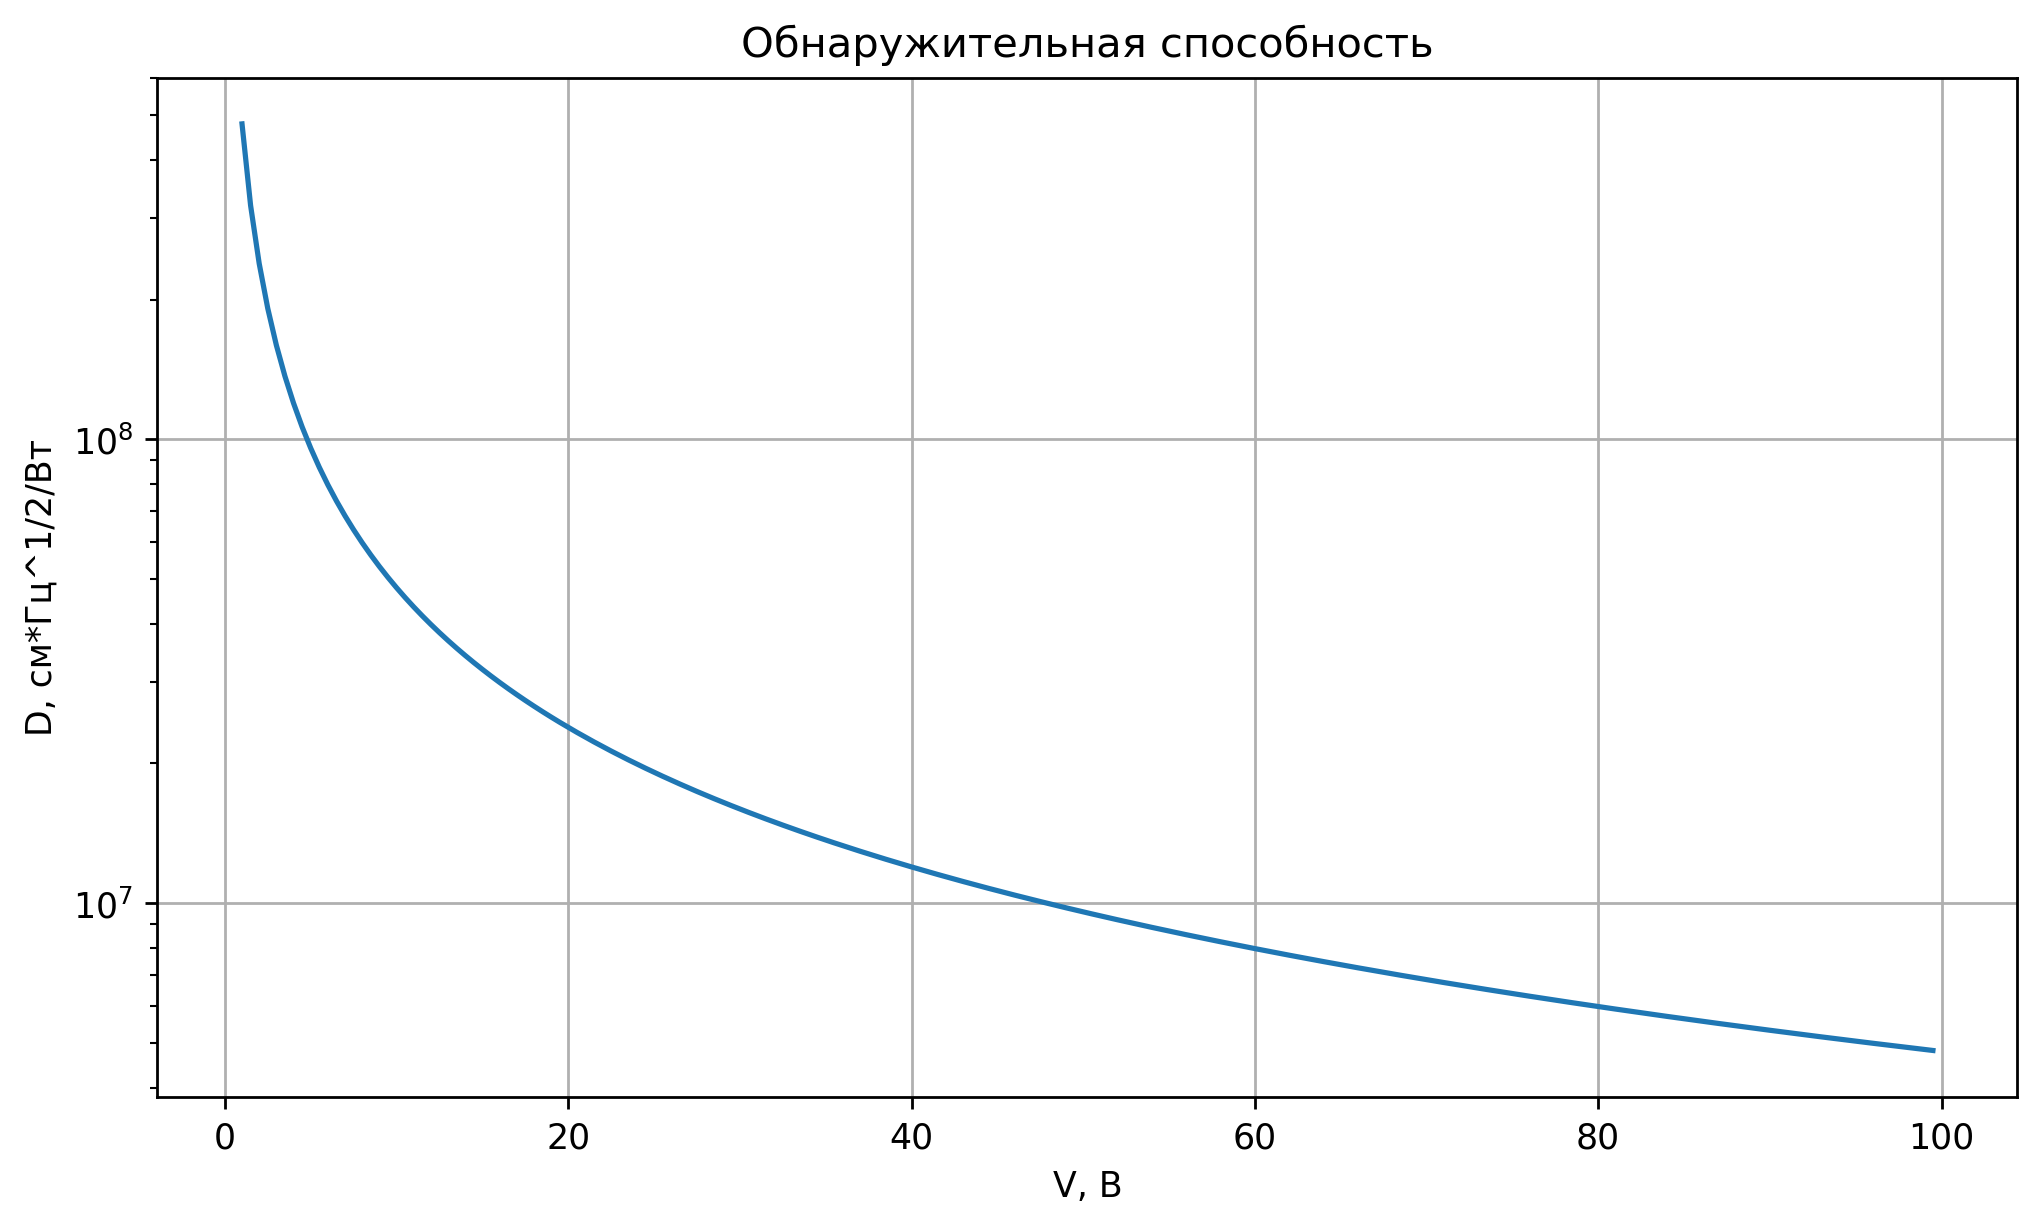

In [34]:
Vol=np.arange(1, 100, 0.5)
Iphs = np.zeros(len(Vol))
for i in range(0, len(Vol)):
    Iphs[i] = Vol[i]/(2*Rs0)

In = np.zeros(len(Vol))
for i in range(0, len(Vol)):
    In[i]=np.sqrt(1/155*(4*Iphs[i]**2*(un/up+1)**2*nn[34]*t)/((un/up*ni+ni)*2*(1+t**2+(2*np.pi*c/1.45e-6))))

D = np.zeros(len(Vol))
for i in range(0, len(Vol)):
    D[i]=(Sin*np.sqrt(1*176))/(In[i])
  
fig, ax = plt.subplots()        
plt.rcParams['figure.dpi'] = 250 
plt.rcParams["figure.figsize"] = (9.6,5.4)
plt.rcParams["axes.grid"] = True
ax.set_xlabel("V, В") 
ax.set_ylabel("D, см*Гц^1/2/Вт") 
ax.set_title('Обнаружительная способность')
ax.plot(Vol, D);
ax.set_yscale('log')